<a href="https://colab.research.google.com/github/royam0820/LLM_OCR/blob/main/amr_0_Mistral_structured_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installs the Mistral AI library silently without outputting the installation logs.
!pip install mistralai


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\aliou\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Download PDF and image files

## Mistral OCR with PDF

We will need to set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [2]:
# # Sets up the Mistral client for making API requests.
import os

api_key = os.environ.get('MdYKya1ABtT13jDBfYLWQGnK8GC5C7dl')

# Initialize Mistral client with API key
from mistralai import Mistral

client = Mistral(api_key='MdYKya1ABtT13jDBfYLWQGnK8GC5C7dl')

In [9]:
from pathlib import Path
import json, os, time

# Imports robustes selon version du SDK
try:
    from mistralai import FileChunk
except Exception:
    from mistralai.models import FileChunk

# ===================== OPTIONS =====================
PDF_PATH = r"C:/Users/aliou/OneDrive/Desktop/Mes projets/document_OCR_LLM/compromis-ANSELME_opt.pdf"
INCLUDE_IMAGE_BASE64 = True   # Mets False si tu n'as pas besoin des images -> réponses plus légères
FLATTEN_ANNOTATIONS = True    # Aplatir stylo/tampons/annotations avant OCR (recommandé)
MAX_RETRIES = 3               # Réessais côté client (réseau/API)
BACKOFF_BASE = 0.75           # secondes (exponentiel: 0.75s, 1.5s, 3s)
# ===================================================

# (Optionnel) exposer le chemin source pour tes fonctions d'affichage/markdown
ORIGINAL_PDF_PATH = PDF_PATH  # utilisé par ton get_combined_markdown()

# ---------- Utils ----------
def call_with_backoff(fn, *args, **kwargs):
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            if attempt == MAX_RETRIES:
                raise
            delay = BACKOFF_BASE * (2 ** (attempt - 1))
            print(f"[WARN] {fn.__name__} tentative {attempt} échouée: {e}. Retry dans {delay:.2f}s...")
            time.sleep(delay)

def _extract_file_id(up):
    for attr in ("id", "file_id"):
        v = getattr(up, attr, None)
        if v:
            return v
    inner = getattr(up, "file", None)
    if inner is not None:
        v = getattr(inner, "id", None)
        if v:
            return v
    if isinstance(up, dict):
        return up.get("id") or up.get("file_id") or (up.get("file") or {}).get("id")
    return None

def flatten_pdf_if_needed(pdf_in: Path) -> Path:
    """Aplatit les annotations (stylo/tampons) en rasterisant le PDF. Ignoré si PyMuPDF indisponible."""
    if not FLATTEN_ANNOTATIONS:
        return pdf_in
    try:
        import fitz  # PyMuPDF
    except Exception as e:
        print(f"[WARN] Flatten ignoré (PyMuPDF manquant: {e})")
        return pdf_in

    try:
        doc = fitz.open(str(pdf_in))
        out = pdf_in.with_name(pdf_in.stem + "_flattened.pdf")
        zoom = 300 / 72.0
        mat = fitz.Matrix(zoom, zoom)
        out_doc = fitz.open()
        for page in doc:
            pix = page.get_pixmap(matrix=mat, annots=True, alpha=False)
            img = fitz.open("png", pix.tobytes("png"))
            rect = img[0].rect
            pdfbytes = img.convert_to_pdf()
            imgpdf = fitz.open("pdf", pdfbytes)
            newp = out_doc.new_page(width=rect.width, height=rect.height)
            newp.show_pdf_page(rect, imgpdf, 0)
        out_doc.save(str(out))
        out_doc.close()
        doc.close()
        print(f"[INFO] PDF aplati: {out}")
        return out
    except Exception as e:
        print(f"[WARN] Flatten échoué, on continue sur l'original: {e}")
        return pdf_in

# ---------- Main ----------
pdf_file = Path(PDF_PATH)
assert pdf_file.is_file(), f"Fichier introuvable: {pdf_file}"

pdf_for_ocr = flatten_pdf_if_needed(pdf_file)

# Upload (avec backoff)
uploaded_file = call_with_backoff(
    client.files.upload,
    file={"file_name": pdf_for_ocr.name, "content": pdf_for_ocr.read_bytes()},
    purpose="ocr",
    retries=3,  # si supporté par ta version du SDK
)
print("[INFO] Upload OK:", uploaded_file)

# file_id
file_id = _extract_file_id(uploaded_file)
assert file_id, f"file_id vide depuis la réponse: {uploaded_file}"
print("[INFO] file_id:", file_id)

# Vérification côté serveur (utile pour diagnostiquer les 404)
info = call_with_backoff(client.files.retrieve, file_id=file_id)
print(f"[INFO] Fichier côté serveur: {getattr(info, 'filename', None)} ; purpose={getattr(info, 'purpose', None)}")

# OCR (FileChunk direct) avec backoff
pdf_response = call_with_backoff(
    client.ocr.process,
    document=FileChunk(file_id=file_id),
    model="mistral-ocr-latest",
    include_image_base64=INCLUDE_IMAGE_BASE64,
)

# Sortie JSON (dict direct)
resp_dict = pdf_response.model_dump()
print(json.dumps(resp_dict, indent=2)[:1000])  # aperçu

# Sauvegardes utiles
out_json = pdf_for_ocr.with_suffix(".ocr.json")
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(resp_dict, f, ensure_ascii=False, indent=2)
print(f"[INFO] JSON complet écrit: {out_json}")


[INFO] PDF aplati: C:\Users\aliou\OneDrive\Desktop\Mes projets\document_OCR_LLM\compromis-ANSELME_opt_flattened.pdf
[INFO] Upload OK: id='cc43c72b-ec37-41b7-8fc7-68d47dbc01ce' object='file' size_bytes=42883277 created_at=1755980846 filename='compromis-ANSELME_opt_flattened.pdf' purpose='ocr' sample_type='ocr_input' source='upload' num_lines=0 mimetype='application/pdf' signature='d86c37179cbc8320fa2b314c16a3f1c1'
[INFO] file_id: cc43c72b-ec37-41b7-8fc7-68d47dbc01ce
[WARN] retrieve tentative 1 échouée: API error occurred: Status 404
{"detail": "No file matches the given query."}. Retry dans 0.75s...
[WARN] retrieve tentative 2 échouée: API error occurred: Status 404
{"detail": "No file matches the given query."}. Retry dans 1.50s...
[INFO] Fichier côté serveur: compromis-ANSELME_opt_flattened.pdf ; purpose=ocr
{
  "pages": [
    {
      "index": 0,
      "markdown": "# COMPROMIS DE VENTE \n\n## de biens et droits immobiliers\n\n## MANDATAIRE\n\nEn pr\u00e9sence et avec le concours de (1

NB1: differences between `DocumentURLChunk` and `TextChunk``

- `DocumentURLChunk` is designed to encapsulate a URL reference to a document (such as a PDF) that the OCR service can download and process, whereas
- `TextChunk` is a simple container for raw text content (for example, instructions or OCR results) that you want to send directly to a language model.

NB2: A signed URL is a secure, temporary link that grants access to a protected file without requiring additional authentication.In this code, after the file (e.g., a PDF) is uploaded, the service generates a signed URL that allows the OCR engine to access the file for processing. The URL includes an embedded token that validates your permission to access the file and is set to expire after a short period (as specified by the expiry parameter), which enhances security by ensuring the link can't be misused after its expiration.

View the result with the following:

In [11]:
import json


# --- Imports robustes pour les chunks ---
try:
    from mistralai import TextChunk
except Exception:
    from mistralai.models import TextChunk

# --- Récupérer le markdown OCR (toutes les pages si dispo) ---
# Utilise pdf_response (objet SDK) OU resp_dict (dict) selon ce que tu as en mémoire.
def _build_pdf_ocr_markdown(pdf_response=None, resp_dict=None) -> str:
    # Cas 1 : objet SDK
    pages_obj = getattr(pdf_response, "pages", None)
    if pages_obj:
        return "\n\n---\n\n".join((getattr(p, "markdown", "") or "") for p in pages_obj).strip()
    # Cas 2 : dict (model_dump)
    if isinstance(resp_dict, dict):
        pages = resp_dict.get("pages") or []
        if pages:
            return "\n\n---\n\n".join((p.get("markdown") or "") for p in pages).strip()
    return ""

pdf_ocr_markdown = _build_pdf_ocr_markdown(pdf_response=pdf_response, resp_dict=resp_dict)
assert pdf_ocr_markdown, "OCR n'a renvoyé aucun markdown (pages vides)."

# --- Appel LLM pour convertir le markdown OCR en JSON structuré ---
chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                TextChunk(
                    text=(
                        "Voici le résultat OCR d’un document (image) au format Markdown :\n\n"
                        f"{pdf_ocr_markdown}\n\n"
                        "Retourne STRICTEMENT un OBJET JSON valide (pas de tableau à la racine), sans aucun texte hors JSON. "
                        "Ne présuppose aucun schéma : utilise les titres/sections/étiquettes visibles dans le document comme clés, "
                        "et organise les informations de manière HIÉRARCHIQUE (évite les listes plates de paires 'field'/'value'). "
                        "Inclue autant d’informations que possible "
                        "en reprenant les libellés tels qu’imprimés. "
                        "Quand c’est pertinent, indique la page d’origine pour chaque élément, et représente les tableaux naturellement "
                        "(colonnes + lignes). "
                        "N’invente rien : ne renvoie que ce qui figure réellement dans le texte OCR. "
                        "En cas de doublons, déduplique et garde la version la plus complète. "
                        "La sortie doit être un OBJET JSON unique, propre, lisible et auto-descriptif."
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# --- Récupération robuste du JSON renvoyé ---
# Selon le SDK, le contenu peut être une chaîne ou une liste de segments (chunks)
content = None
try:
    content = chat_response.choices[0].message.content
except Exception:
    # Repli au cas où certaines versions exposent d'autres attributs
    content = getattr(chat_response, "output_text", None) or getattr(chat_response, "content", None)

if isinstance(content, list):
    # Concatène les parties textuelles si le SDK renvoie une liste de segments
    texts = []
    for c in content:
        t = getattr(c, "text", None)
        if t:
            texts.append(t)
        elif isinstance(c, dict) and c.get("text"):
            texts.append(c["text"])
    content = "".join(texts)

content = (content or "").strip()

# Si le modèle a ajouté du texte autour, on isole la portion JSON entre le 1er { ou [ et le dernier } ou ]
if not (content.startswith("{") or content.startswith("[")):
    starts = [pos for pos in (content.find("{"), content.find("[")) if pos != -1]
    ends = [pos for pos in (content.rfind("}"), content.rfind("]")) if pos != -1]
    assert starts and ends, f"Réponse non-JSON : {content!r}"
    content = content[min(starts):max(ends)+1]

# Parse JSON ; si c'est un tableau, on l'emballe dans un objet standard
parsed = json.loads(content)
response_dict = {"items": parsed} if isinstance(parsed, list) else parsed

print(json.dumps(response_dict, indent=4, ensure_ascii=False))



{
    "compromis_de_vente": {
        "titre": "COMPROMIS DE VENTE",
        "sous_titre": "de biens et droits immobiliers",
        "mandataire": {
            "agence": "STE MARIE-IMMOBILIER TRANSACTIONS - LOCATIONS",
            "adresse": "44, Avenue des Marendes",
            "code_postal": "66470",
            "ville": "STE-MARIE-LA-MER",
            "telephone": "0468730421",
            "siret": "80091101800011"
        },
        "mentions_manuscrites": {
            "droit_de_retractation": "Remis par 5e Marie Immobilier à Sainte Marie la Mer le 30 juillet 2025 et le déclare avoir connaissance qu'un délai de rétractation de dix jours n'est accordé par l'article L. 271-1 du code de la construction et de l'habitation, et qu'il court à compter du lendemain de la date de remise inscrite de ma main sur le présent acte, soit à compter du 31 juillet 2025"
        },
        "soussignes": {
            "vendeur": {
                "nom": "Stewart Jones",
                "adresse": "2

## Contexte du PDF
### Métadonnées
- **creator** : Nitro Pro 10
- **modDate** : D:20250818142153+02'00'

### Signatures
**Champs de signature détectés** : 0
_Aucun champ de signature détecté._

### Annotations (non rendues par l’OCR)
_Aucune annotation détectée._

### Cases à cocher / champs de formulaire
_Aucun champ de formulaire (cases) détecté._

# COMPROMIS DE VENTE

## de biens et droits immobiliers

## MANDATAIRE

En présence et avec le concours de (1) représentant (2)

## AGENCE <br> STE MARIE-IMMOBILIER <br> TRANSACTIONS - LOCATIONS <br> 44, Avenue des Marendes <br> 66470 STE-MARIE-LA-MER <br> Tél. 0468730421 <br> Siret : 80091101800011

Cadre réservé aux mentions manuscrites dans le seul cas où le mandataire notifie le présent acte au acquéreur par remise en main propre (1) (article D. 271-8 du code de la construction et de l'habitation)

Le(s) bénéficiaire(s) du droit de rétractation inscrit(vent) de sa(leur) main les mentions suivantes :

"Remis par (nom du mandataire désigné en page 1) ... à (lieu) ... le (date) ... et "le déclare avoir connaissance qu'un délai de rétractation de dix jours n'est accordé par l'article L. 271-1 du code de la construction et de l'habitation, et qu'il court à compter du lendemain de la date de remise inscrite de ma main sur le présent acte, soit à compter du ... ".

"Remis par 5e Marie Immobilier à Sainte Marie la Mer le 30 juillet 2025" et "le déclare avoir connaissance qu'un délai de rétractation de dix jours n'est accordé par l'article L. 271-1 du code de la construction et de l'habitation, et qu'il court à compter du lendemain de la date de remise inscrite de ma main sur le présent acte, soit à compter du 31 juillet 2025".

(1) pour faire courir le délai de rétractation l'article D. 271-6 du CCH exige, outre la mention manuscrite, la reproduction intégrale de l'article L. 271-2 (cf page 14 des présentes).

# LES SOUSSIGNÉS

## VENDEUR(S) (1)

**Cf. Stewart Jones** 24me Kelly Jones
Christchurch
BH 23 7
29 30 SOPLEY MILLANE
ROYAUME UNI

**Dait:** StewartJones@hotmail.co.uk

**d'une part,**

**ET:**

**ACQUÉREUR(S) (1)**

**Pme Cendie, daure ANSELME**
née le 31 Mars 1987 à Bron (64)
Divorcée de D. Jean Gérard Buffon
au TGI de Pointe à Pline

**Domiciliée:** 2, avenue du Paca
32, résidence du lac
66 420 de Barcaires

**Tél. 06 15 39 40 33**

**Dait:** cjendie-buffon@mail.com

**d'autre part,**

Si interviennent à la vente plusieurs VENDEURS et/ou plusieurs ACQUÉREURS, ceux-ci seront réputés agir conjointement et solidairement entre eux sous la désignation "le VENDEUR" et "l'ACQUÉREUR".

**ONT CONVENU ET ARRÊTÉ CE QUI SUIT:**

Le VENDEUR, en s'obligeant et en obligeant ses héritiers et ayants droit solidairement entre eux, fussent-ils mineurs ou incapables, à toutes les garanties ordinaires et de droit les plus étendues, **vend à l'ACQUÉREUR qui accepte et s'engage à acquérir sous réserve des conditions suspensives énoncées aux présentes**, les biens et droits immobiliers désignés ci-après.

**ADRESSE**

(1) rue, étage, bâtiment, n° de porte, code postal, ville)

**66 490 St Paris La Pye**
**Rédicace:** Section AM 60253
**Ris. d'ou bontalon.**

(1) Pour chaque personne physique, indiquer : nom, présence, domicile, date et lieu de naissance, nationalité, profession, état matrimonial ou pack.
(2) Pour les sociétés, indiquer : forme, dénomination, capital social, siège, n° RCS, nom, qualité et adresse de son représentant.

**Parcours**

# DÉSIGNATION

Préciser les renseignements du cadastre (section, n) - Le cas échéant, préciser que le bien est en copropriété, le nombre et les n° de lots, le nombre de millénaires - les Cours : superficie privative des lots supérieurs à 8m2 à l'exclusion des lots à usage de cave, garage et emplacement de stationnement (mention obligatoire, article 46 de la loi du 10.07.1965), nom, prénoms, adresse et qualité de la personne ayant effectué le mesurage et annexer le document du mesurage aux présentes.

## N°38 (lot) : Maison de type C3 située dans le hameau de Comprenant

- RDC : bijou, coin cuisine, salle de aune
- WC, une chambre avec placard, véranda,
- jouissance privative du jardin et à l'éloge
- mezzanine portant le N°6,8 du plan.
- Et les 22110 000 éms des parties communes

## SÉCURITÉS

- **Lot N°38** : jouissance d'un partie à l'air libre
- **Patent le N°6 du plan** : et les 5/10 000 éms des parties
- tels que lesdits biens existent et se comportent dans leur état actuel, avec toutes les dépendances, sans autorisation d'accueil.
- l'ACQUÉREUR déclarant les bien connaître pour les avoir vus et visités et dispensant le VENDEUR d'une plus ample désignation.

## 1 - DÉCLARATIONS DU VENDEUR

### Le VENDEUR déclare :

1. **SUR L'ÉTAT CIVIL** : Qu'il s'oblige à faire dans l'acte de réalisation des présentes les déclarations civiles d'usage et que rien dans ces déclarations ne s'oppose à cette réalisation.
2. **INFORMATION PRÉALABLE** : le VENDEUR déclare avoir porté à la connaissance de l'ACQUÉREUR les informations dont il dispose concernant l'immeuble, ayant un lien direct et nécessaire avec le contenu du présent compromis de vente, dont l'importance pourrait être déterminante pour le consentement de l'ACQUÉREUR. Cette information ne porte pas sur la valeur de la prestation.
3. **SUR L'ORIGINE DE PROPRIÉTÉ** : Qu'il est seul propriétaire des biens pour les avoir acquis et s'engage à fournir, à première demande du mandataire, tous titres de propriété et pièces nécessaires à la vente :

   - Renseignements concernant l'acte d'acquisition

   - Précédent propriétaire :
      - **Clerckames DESPIERRES**

   - Date, nature de l'acte et mentions de l'enregistrement
      - Le 30 juin 2017 chez Daitre Pagnon a
      - Surnatement de la personne

4. **SUR LES SERVITUDES ET L'URBANISME** : Que les biens, objet des présentes, ne sont à sa connaissance grevés d'aucune servitude autre que celles résultant de la situation naturelle des lieux, du plan d'aménagement et d'urbanisme et de la loi en général, les questions d'urbanisme faisant ci-après l'objet d'une condition suspensive.
5. **SUR LA SITUATION HYPOTHÉCAIRE** : Que les biens à vendre sont libres de tout privilège immobilier spécial et de toutes hypothèques conventionnelles, judiciaires ou légales. Si des inscriptions hypothécaires se révélaient, il s'oblige à en rapporter mainlevée et certificat de radiation à ses frais.
6. **SUR SES OBLIGATIONS DE PROPRIÉTAIRE** : Qu'il a satisfait à toutes ses obligations de propriétaire relativement au bien vendu (notamment, selon les caractéristiques du bien, informations relatives à la construction et à la rénovation dudit bien, souscription d'assurance, sécurité des piscines, division du terrain, entretien chaudière, détecteur de fumée...).

   - Le cas échéant, les dispositions prises pour une obligation non satisfaite sont précisées au paragraphe VI - "AUTRES CONDITIONS PARTICULIÈRES".

7. **SUR L'ÉTAT D'OCCUPATION** :

   - Que ces biens seront le jour de l'entrée en jouissance
   - **X** libres de toute location, occupation, réquisition ou encombrement.
   - **Y** loués selon l'état local d'annexe aux présentes.

   - Si les locaux sont vendus loués, la restitution du dépôt de garantie incombe au nouveau BAILLEUR. Toute clause contraire entre le VENDEUR et l'ACQUÉREUR est inapposable au locataire.

8. **SUR LA SITUATION DE L'IMMEUBLE AU REGARD DE LA COPROPRIÉTÉ** :

   - **A : APUREMENT DES CHARGES DE LA COPROPRIÉTÉ (le cas échéant)** :

   - Qu'il s'oblige à obtenir, à la date prévue pour la signature de l'acte authentique, le certificat mentionnant l'apurement des charges de copropriété (article 20 - loi du 10.07.1965), auprès du syndic désigné ci-dessous :

   - Coordonnées du syndic

   - Nom et adresse :
      - 44 av, des Parendes 66 (10) 5h00 min 6h00
   - **Fax**

# B - INFORMATION DE L'ACQUÉREUR (article L. 721-2 du code de la construction et de l'habitation) :

Si le lot ou la fraction de lot vendu d'un immeuble bâti est à usage total ou partiel d'habitation, doivent avoir été remis à l'ACQUÉREUR sur tout support et par tout moyen, au plus tard le jour de la signature du présent avant-contrat, les informations et documents suivants :

- la fiche synthétique de la copropriété prévue à l'article 8-2 de la loi du 10 juillet 1965 ;
- le règlement de copropriété et l'état descriptif de division ainsi que les actes les modifiant s'ils ont été publiés ;
- les procès-verbaux des assemblées générales des trois dernières années, sauf si le copropriétaire VENDEUR n'a pas été en mesure d'obtenir ces documents auprès du syndic ;
- les informations financières suivantes :
  - le montant des charges courantes du budget prévisionnel et des charges hors budget prévisionnel payées par le copropriétaire VENDEUR au titre des deux exercices comptables précédant la vente ;
  - les sommes susceptibles d'être dues au syndicat des copropriétaires par l'ACQUÉREUR ;
  - l'état global des impayés de charges au sein du syndicat et de la dette vis-à-vis des fournisseurs ;
  - lorsque le syndicat des copropriétaires dispose d'un fonds de travaux, le montant de la part du fonds de travaux rattaché au lot principal vendu et le montant de la dernière cotisation au fonds versée par le copropriétaire VENDEUR au titre du lot ;

Par exception, les syndicats comportant moins de dix lots à usage de logements, de bureaux ou de commerces, dont le budget prévisionnel moyen sur une période de trois exercices consécutifs est inférieur à 15 000 Euros, n'ont pas à communiquer les sommes susceptibles d'être dues par l'ACQUÉREUR ainsi que l'état global des impayés ;

À l'exception des sommes susceptibles d'être dues par l'ACQUÉREUR, ces informations financières sont à jour des informations soumises à la dernière assemblée générale annuelle chargée d'approuver les comptes.

- le carnet d'entretien de l'immeuble (contenu défini par le décret n°2001-477 du 30.05.2001) ;
- une notice d'information relative aux droits et obligations des copropriétaires ainsi qu'au fonctionnement des instances du syndicat de copropriété dont le contenu est fixé par arrêté ;
- le cas échéant, les conclusions du diagnostic technique global.
- Le cas échéant, le plan pluriannuel de travaux adopté dans les conditions prévues au premier alinéa du II de l'article 14-2 de la loi n° 65-557 ou à défaut, le projet de plan pluriannuel de travaux mentionné au premier alinéa du I de l'article 14-2 de la loi n° 65-557, s'il a été élaboré.

Lorsque l'ACQUÉREUR est déjà propriétaire d'un lot au moins dans la copropriété, seules les informations financières sont requises ; lorsque l'avant-contrat porte sur la vente d'un lot annexe (remise, cave, place de stationnement, garage, etc.), seuls la fiche synthétique de copropriété, le règlement de copropriété et les informations financières sont requis.

L'ACQUÉREUR atteste de la remise des éléments du présent B - dans un document qu'il signe et date de sa main.

**ATTENTION :** Lorsque l'ensemble de ces documents et informations SAUF le carnet d'entretien, la notice d'information et le diagnostic technique global n'ont pas été remis à l'ACQUÉREUR à la date de signature de l'avant-contrat, le délai de rétractation ou de réflexion ne court qu'à compter du lendemain de la communication de ces documents et informations à l'ACQUÉREUR.

Cette communication est réalisée selon les modalités de notification ou de remise de l'avant-contrat prévues à l'article L. 271-1 du CCH.

# C - RÉPARTITION DES CHARGES DE COPROPRIÉTÉ À LA DATE DE LA CESSION (le cas échéant) :

Aux termes de l'article 6-2 du décret du 17.03.1967, le principe de répartition des provisions sur charges à l'occasion de la mutation à titre onéreux d'un lot de copropriété est le suivant :

- le paiement de la provision exigible du budget prévisionnel, en application du 3ème alinéa de l'article 14-1 de la loi du 10.07.1965, **incombe au VENDEUR** ;
- le paiement des provisions des dépenses non comprises dans le budget prévisionnel incombe à celui, VENDEUR ou ACQUÉREUR, qui est copropriétaire au moment de l'exigibilité ;
- le trop ou moins perçu sur provisions, révélé par l'approbation des comptes, est porté au crédit ou au débit du compte de celui qui est copropriétaire lors de cette approbation.

Cependant, aux termes de l'article 6-3 du décret du 17.03.1967, toutes les clauses répartissant les charges entre le VENDEUR et l'ACQUÉREUR d'un lot sont possibles ; le cas échéant, la convention de répartition de charges est indiquée dans les "AUTRES CONDITIONS PARTICULIÈRES" en page 11. Ces stipulations n'ont d'effet qu'entre les parties.

Le syndic conserve donc pour débiteur celui que les dispositions ci-dessus désignent.

# D - ASSEMBLÉE GÉNÉRALE DES COPROPRIÉTAIRES ENTRE LE COMPROMIS ET L'ACTE AUTHENTIQUE DE VENTE (le cas échéant) :

Le VENDEUR déclare avoir reçu la convocation de la prochaine assemblée générale qui se tiendra à l'Attention de la personne.

Le VENDEUR a remis à l'ACQUÉREUR l'ordre du jour de cette assemblée et ses annexes demeurés ci-annexés.

Si une assemblée générale des copropriétaires est convoquée, une réunion ou consultation des copropriétaires est organisée, entre le présent avant-contrat et l'acte authentique de vente au pour une date postérieure à la date prévue pour la signature de l'acte authentique, le VENDEUR s'engage à transmettre sans délai à l'ACQUÉREUR l'ordre du jour, ses annexes et le mandat de l'y représenter.

9 - SUR LA SITUATION DE L'IMMEUBLE AU REGARD DES DIAGNOSTICS TECHNIQUES :

A - DOSSIER DE DIAGNOSTIC TECHNIQUE (article L. 271-4 du CCH) :

L'immeuble a été construit le 21927

Le VENDEUR remet, dès la signature des présentes, le dossier de diagnostic technique contenant les éléments ci-dessous établis par un ou plusieurs diagnostiqueurs certifiés (article L. 271-6 du CCH).

Article R.271-4 du CCH (extrait) : "(...) Est puni de l'amende prévue pour les contraventions de la cinquième classe le fait : ...

c) De faire appel, en vue d'établir un document devant être établi dans les conditions prévues à l'article L. 271-6, à une personne qui ne satisfait pas aux conditions de compétences, d'organisation et d'assurance définies aux articles R. 271-1 et R. 271-2 ou aux conditions d'impartialité et d'indépendance exigées à l'article L. 271-6. (...)".

X Un état des risques naturels et technologiques : établi le 2210712025
(ERP : état des risques et pollutions)
et daté de moins de 6 mois car l'immeuble est situé dans une zone visée au I de l'article L. 125-5 du code de l'environnement ou par un arrêté préfectoral prévu au III du même article ;
L'immeuble est situé dans une zone :
[ ] couverte par un plan de prévision des risques technologiques ;
[x] couverte par un plan de prévention des risques naturels prévisibles ;
[x] sismique ;
[ ] couverte par un plan de prévention des risques miniers ;
[ ] en Secteur d'Information sur les Sols (SIS) ;
[ ] à potentiel radon classée niveau 3.

Si, après le compromis de vente, la parcelle sur laquelle est implanté l'immeuble est inscrite dans une des zones mentionnées au I de l'article L. 125-5 du code de l'environnement ou l'arrêté préfectoral prévu au III du même article fait l'objet d'une mise à jour, le dossier de diagnostic technique est complété lors de la signature de l'acte authentique de vente par un état des risques naturels et technologiques ou par la mise à jour de l'état existant.

Le VENDEUR est tenu d'informer par écrit l'ACQUEREUR de l'existence de tout sinistre ayant donné lieu au versement d'une indemnité et survenu pendant la période où il a été propriétaire de l'immeuble ou dont il a été lui-même informé.

En cas de sinistre survenu depuis le 1er janvier 2024 lié au phénomène naturel de mouvements de terrain différentiels consécutifs à la sécheresse et à la réhydratation des sols, et lorsque le vendeur possède le rapport d'expertise qui lui a été communiqué par l'assureur, le vendeur est tenu d'informer l'acquéreur des travaux permettant un arrêt des désordres existants non réalisés bien qu'ayant été indemnisés ou ouvrant droit à une indemnisation survenue pendant la période au cours de laquelle le vendeur en a été propriétaire.

L'information doit être jointe à l'avant-contrat de vente et la liste de travaux doit être jointe à l'état des risques.

Le VENDEUR certifie [x] que l'immeuble objet des présentes n'a fait l'objet d'aucun sinistre lié au phénomène de catastrophe naturelle ou technologique ayant donné lieu au versement d'une indemnité ;
[ ] que l'immeuble objet des présentes a fait l'objet d'un sinistre lié au phénomène de catastrophe naturelle ou technologique ayant donné lieu au versement d'une indemnité.

En l'absence, lors de la signature de l'acte authentique de vente, de l'état des risques naturels et technologiques, l'ACQUÉREUR peut poursuivre la résolution du contrat ou demander ou juge une diminution du prix.

[ ] Un état des nuisances sonores aériennes : établi le Exclu
qui détermine si l'immeuble est situé dans une zone définie par un plan d'exposition au bruit qui n'a qu'une valeur indicative. La responsabilité du VENDEUR ne pouvant être mise en cause par L'ACQUÉREUR, sauf s'il est avéré que l'immeuble est situé dans une telle zone qui est consultable sur le site www.geoportail.gouv.fr et que ce plan ne figure pas dans cet état.

[ ] Une information sur la présence d'un risque de mérite dans les zones délimitées en application de l'article L.131-3 du CCH.

[x] Un état relatif à la présence de termites dans le bâtiment établi le 2210712025
et daté de moins de 6 mois (article L. 126-24 du CCH), car l'immeuble (ou partie d'immeuble) bâti est situé dans une zone délimitée en application de l'article L. 131-3 du CCH et concluant :
[x] l'immeuble est situé dans une zone à risque, mais le bien vendu n'est pas affecté ;
[ ] la présence de termites a été déclarée à la mairie.

En cas d'absence de l'état relatif à la présence de termites lors de la signature de l'acte authentique, la découverte de termites constitue un vice caché susceptible d'entacher la vente de nullité.

[ ] Un Constat de Risque d'Exposition au Plomb (CREP) établi le Exclu
daté de moins de 1 an (sauf en cas de précédent contrat concluant à l'absence de plomb), et concernant les parties privatives affectées à l'habitation de l'immeuble construit AVANT le 01.01.1949 concluant :
[ ] à l'absence de plomb ;
[ ] à la présence de plomb en concentration supérieure aux seuils définis par arrêté ministériel ;
[ ] à la présence de plomb en concentration inférieure aux seuils définis par arrêté ministériel.

Paraphes

# Un état mentionnant la présence ou l'absence

de matériaux ou produits contenant de l'amiante établi le **28.107.12025**

car le permis de construire de l'immeuble a été délivré **AVANT le 01.07.1997** et concluant :

- [x] à l'absence d'amiante ;
- [ ] à la présence d'amiante ;
- [ ] dans les parties privatives,
- [ ] dans les parties communes.

## Un état de l'installation intérieure de gaz établi le **28.107.12025**

daté de moins de 3 ans car l'immeuble est à usage d'habitation et l'installation intérieure de gaz a été réalisée depuis plus de 15 ans (article L. 134-9 du CCH).

## Un état de l'installation intérieure d'électricité établi le **28.107.12025**

daté de moins de 3 ans car l'immeuble est à usage d'habitation et l'installation intérieure d'électricité a été réalisée depuis plus de 15 ans (article L. 134-7 du CCH).

**CREP. État de présence ou d'absence d'amiante, État d'installation intérieure de gaz ou État d'installation intérieure d'électricité :** en cas d'absence de ces éléments lors de la signature de l'acte authentique de vente, le VENDEUR ne peut pas s'exonérer de la garantie des vices cachés.

## Un diagnostic de performance énergétique (DPE) établi le **28.107.12025**

- le DPE réalisé après le 01/07/2021 est valable 10 ans ;
- les DPE réalisés entre le 01.01.2013 et le 31.12.2017 ne sont plus valides ;
- les DPE réalisés entre le 01.01.2018 et le 30.06.2021 sont valides jusqu'au 31.12.2024.

## Un diagnostic de performance énergétique collectif établi le

Le DPE collectif est renouvelé ou mis à jour tous les 10 ans, sauf s'il est réalisé après le 1er juillet 2021 et qu'il permet d'établir que le bâtiment appartient à la classe énergétique A, B ou C.

## Audit énergétique

En application de l'article L.126-28-1 du CCH, lorsque des bâtiments ou des parties de bâtiment à usage d'habitation, proposés à la vente en France métropolitaine, comprenant un seul logement ou comportant plusieurs logements ne relevant pas du statut de la copropriété et qui appartiennent aux classes de performance énergétique F ou G, un audit énergétique doit être réalisé depuis le 1er avril 2023. Cette obligation est étendue pour les mêmes biens de classe de performance énergétique E au 1er janvier 2025 et de classe de performance énergétique D au 01.01.2034.

- [ ] Le VENDEUR a fait établir un audit énergétique, une copie est demeurée ci-annexée.
- [ ] Les biens, objets des présentes, ne sont pas soumis à la réglementation relative à l'audit énergétique.

## Un diagnostic assainissement établi le **Via Le Notaire / Eau Agdo**

daté de moins de 3 ans et concluant que l'installation individuelle d'assainissement :

- [x] est conforme à la législation ;
- [ ] n'est pas conforme à la législation et des travaux de mise en conformité devront être réalisés par l'ACQUÉREUR dans les un an qui suivent la signature de l'acte authentique.

Lorsqu'une zone d'assainissement collectif existe, le raccordement au réseau public d'assainissement est obligatoire dans le délai de 2 ans à compter de la mise en service du réseau public de collecte.

## Un carnet d'information du logement (CIL)

Le VENDEUR d'un bien immobilier à usage d'habitation doit remettre à l'ACQUÉREUR un carnet d'information du logement (CIL) en cas de réalisation de travaux de construction et travaux de rénovation ayant une incidence significative sur la performance énergétique du logement, dont les autorisations administratives ou devis ont été acceptés à compter du 01.01.2023.

Le bien vendu : [x] est à usage d'habitation,
- [ ] et n'a pas fait l'objet de tels travaux depuis le 01.01.2023,
- [ ] et a fait l'objet de tels travaux depuis le 01.01.2023,
- [ ] n'est pas à usage d'habitation.

## AUTRES DIAGNOSTICS :

10 - SUR LES TRAVAUX DE CONSTRUCTION/RÉNOVATION SOUMIS À PERMIS DE CONSTRUIRE RÉALISÉS DEPUIS MOINS DE 10 ANS

Des travaux de

ant été réalisés depuis moins de dix ans.

Poursuivra : **Ac. 30**

Le VENDEUR remet les documents ci-dessous :

- Le permis de construire délivré le
- La déclaration d'achèvement et de conformité des travaux déposée le
- L'attestation de non-contestation à la déclaration d'achèvement et de conformité des travaux
- Une copie de l'assurance dommage ouvrage
- Une copie des assurances décennales
- L'étude géotechnique préalable délivrée le
- L'attestation retrait - gonflement des argiles établie le

## II - PRIX DE VENTE

La vente, si elle se réalise, aura lieu moyennant le prix indiqué ci-dessous et payable en totalité le jour de la signature de l'acte authentique.

Le prix ne comprend pas les honoraires si ceux-ci sont à la charge de l'ACQUÉREUR.

PRIX DU BIEN IMMOBILIER

Somme en toutes lettres: **Leat quaaute sept mille euros**

Somme en chiffres: **147 000 euros**

Le cas échéant, prix des meubles meublant vendus avec le bien immobilier.

PRIX DES MEUBLES MEUBLANT

Somme en toutes lettres: **Sept mille euros**

Somme en chiffres: **7 000 euros**

De convention expresse, le versement effectif de la totalité du prix et du montant des frais ainsi que la signature de l'acte authentique nécessaire pour la publication foncière conditionneront le transfert du droit de propriété au profit de l'ACQUÉREUR.

## III - PROPRIÉTÉ - JOUISSANCE

L'ACQUÉREUR sera propriétaire des biens à vendre à compter du jour de la signature de l'acte authentique. Il en prendra la jouissance à la date indiquée ci-contre par la prise de possession réelle ou par la perception des loyers.

Le VENDEUR s'oblige, jusqu'à signature de l'acte authentique, à conserver en bon état le bien jusqu'à sa délivrance, en y apportant tous les soins d'une personne raisonnable.

La vente est consentie et acceptée sous les conditions ordinaires et de droit que l'ACQUÉREUR s'oblige à accomplir :

1. **JOUISSANCE** : Prendre les biens vendus dans l'état où ils se trouveront le jour de l'entrée en jouissance, sans garantie de la part du VENDEUR de bonne foi en raison du bon ou mauvais état du sol, du sous-sol ou des bâtiments, des vices de toute nature apparents ou cachés, d'une erreur dans la désignation ou la contenance, celle-ci fût-elle supérieure ou inférieure à 1/20ème, devant faire son profit ou sa perte. Toutefois, la présente clause sera considérée sans objet si le VENDEUR est un professionnel de l'immobilier.

2. **GARANTIE DE LA SUPÉRICIE** : Pour les lots de copropriété, la superficie desdits lots telle qu'elle est indiquée dans la désignation qui précède fait l'objet de la garantie instituée par l'article 46 de la loi du 10.07.1965 (loi Carres).

3. **SERVITUDES** : Souffrir les servitudes passives, apparentes ou non, continues ou discontinues, pouvant grever les biens vendus, profiter de celles actives s'il en existe.

4. **TAXES - CHARGES** : Acquitter, à compter du jour de l'entrée en jouissance, les impositions, taxes et charges de toute nature auxquelles les biens sont ou seront assujettis, étant précisé que la taxe foncière sera payée par les deux parties, au prorata de leur occupation dans l'année civile de l'entrée en jouissance.

Autres répartitions des charges

Selon la loi SRu

5. **ASSURANCES** : Faire son affaire personnelle de la continuation ou de la résiliation des polices d'assurance et abonnements divers souscrits par le VENDEUR et relatifs aux biens vendus. Dans tous les cas, maintenir ces derniers assurés à une compagnie notoirement solvable.

6. **FRAIS** : Payer tous les frais, droits et honoraires des présentes et ceux qui en seront la suite ou en constatent les mêmes

# IV - FINANCEMENT

## FINANCEMENT DE L'ACQUISITION SANS EMPRUNT (1)

## A - SOMME A FINANGER

- Prix de la vente
- Prix des meubles meublant
- Provision pour frais d'acte
- Frais de négociation (si ceux-ci sont prévus à la charge de l'ACQUÉREUR)
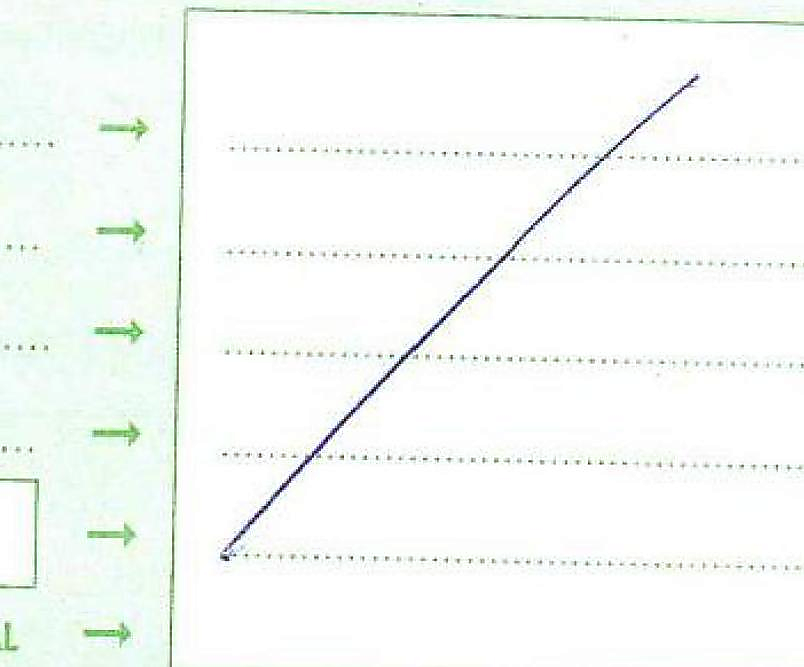

## B - PLAN DE FINANCEMENT

L'ACQUÉREUR déclare qu'il n'envisage pas de contracter d'emprunt pour financer son acquisition, ce financement devant être assuré pour la totalité à l'aide de ses deniers personnels et assimilés.
L'ACQUÉREUR est informé que la signature du compromis de vente sans condition suspensive de l'obtention de prêt signifie que l'acquisition du bien ne dépendra pas de l'obtention d'un prêt auprès d'un organisme financier. Par conséquent, si toutes les autres conditions suspensives prévues au compromis se réalisent, il y aura accord entre les PARTIES sur le prix et la chose et la vente sera alors considérée comme parfaite, au sens de l'article 1583 du code civil. L'ACQUÉREUR, dans ces conditions, sera obligé d'acheter le bien, aux prix et conditions prévus au titre du présent avant-contrat. Sauf à perdre l'indemnité d'immobilisation et en dehors du délai de rétractation de dix jours à compter de la signature de l'avant-contrat, l'ACQUÉREUR ne pourra se dédire.
Il confirme ci-après son intention, par une mention écrite de sa main, conformément à l'article L. 313-42 du code de la consommation.

## DÉCLARATION(S) MANUSCRITE(S) DE L'ACQUÉREUR OU DES CO-ACQUÉREURS

"Je soussigné(e) (nom et prénoms) déclare effectuer cette acquisition sans recourir à aucun prêt. Je reconnais avoir été informé(e) que, si je recours néanmoins à un prêt, je ne pourrai me prévaloir de la condition suspensive de son obtention prévue au livre III chapitre III du code de la consommation relatif au crédit immobilier."

# FINANCEMENT DE L'ACQUISITION À L'AIDE D'EMPRUNTS IMMOBILIERS (2)

## A - SOMME À FINANGER

- Prix de la vente ..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# CONDITION SUSPENSIVE RELATIVE AU FINANCEMENT

La présente vente est soumise à la condition suspensive de l'obtention du ou des prêts qui seront sollicités par l'ACQUÉREUR (et, le cas échéant, par le mandataire si l'ACQUÉREUR lui a confié cette mission au paragraphe K) et dont les caractéristiques ont été définies au paragraphe D ci-avant. Cette condition suspensive est stipulée au seul profit de l'ACQUÉREUR.

## P - DUREE ET RÉALISATION DE LA CONDITION SUSPENSIVE

La durée de validité de la présente condition suspensive est fixée ci-comte, étant entendu que, conformément à l'article L. 313-41 du code de la consommation, elle ne peut être inférieure à 1 mois à compter de la date de signature du présent acte :

## Durée

## 45 jours

Date d'ashéance
Le 15/09/2025 a 18 heures

La présente condition suspensive sera considérée comme réalisée dès que l'ACQUÉREUR aura obtenu, dans le délai fixé ciavant, un ou plusieurs prêts couvrant le montant global de la somme à financer par emprunt et répondant aux caractéristiques définies au paragraphe D.

## G - PROROGATION EVENTUELLE DE LA DUREE

Si les parties décidaient, pour des raisons de pure convenance personnelle, de proroger conventionnellement la durée de la présente condition suspensive, cette prorogation ne pourrait se faire que sur demande expresse de l'ACQUÉREUR formulée par écrit et acceptation écrite du VENDEUR.

## H - OBLIGATIONS DE L'ACQUÉREUR

L'ACQUÉREUR s'engage à faciliter l'instruction des dossiers de prêts et à effectuer dans les plus brefs délais toutes les démarches lui incombant directement afin de ne pas augmenter la durée d'immobilisation des biens à vendre, laquelle pourrait constituer pour le VENDEUR un préjudice financier très grave.
Il s'oblige notamment :

- à déposer une ou plusieurs demandes de prêts répondant aux caractéristiques définies ci-avant paragraphe D et couvrant le montant global de la somme à financer par emprunt,
- à fournir, à première demande, tous renseignements et documents et se soumettre à toute visite médicale qui pourront lui être demandés par les organismes financiers sollicités et, le cas échéant, par le mandataire dûment mandaté.

## I - NON-RÉALISATION DE LA CONDITION SUSPENSIVE

Si la condition suspensive n'est pas réalisée dans le délai prévu au paragraphe F, sans que ce défaut incombe à l'ACQUÉREUR et sauf renonciation par ce dernier à ladite condition dans la forme prévue au paragraphe J, chacune des parties retrouvera sa pleine et entière liberté, sans indemnité de part et d'autre.
Dans ce cas, tout versement effectué par l'ACQUÉREUR lui sera immédiatement et intégralement restitué.
En revanche, si la non-obtention des prêts a pour cause la faute, la négligence, la passivité, la mauvaise foi ou tout abus de droit de l'ACQUÉREUR comme en cas de comportements ou de réticences de nature à faire échec à l'instruction des dossiers ou à la conclusion des contrats de prêts, le VENDEUR pourra demander au tribunal de déclarer la condition suspensive de prêt réalisée, en application de l'article 1304-3 du code civil avec attribution de dommages-intérêts pour le préjudice subi du fait de l'immobilisation abusive des biens à vendre.
Dans cette éventualité, l'ACQUÉREUR devra également indemniser le mandataire du préjudice causé par cette faute et le séquestre ne pourra se dessaisir des fonds qui lui sont confiés que d'un commun accord entre les parties ou en vertu d'une décision de justice devenue définitive.

## J - RENONCIATION À LA CONDITION SUSPENSIVE

Si l'ACQUÉREUR décide de renoncer à la présente condition suspensive, soit parce que le montant total des prêts offerts est inférieur à celui des prêts sollicités, soit pour des raisons de pure convenance personnelle, il devra le notifier au VENDEUR et/ou au mandataire avant l'expiration du délai fixé au paragraphe F.
Cette notification, formulée par lettre recommandée avec avis de réception ou remise en main propre contre récépissé, devra obligatoirement contenir la mention manuscrite prévue par l'article L. 313-42 du code de la consommation.

## K - MANDAT DE FINANCEMENT

Pour s'assurer une possibilité supplémentaire de crédit, l'ACQUÉREUR donne mandat exprès au mandataire afin de solliciter en son nom et pour son compte, un ou plusieurs prêts répondant aux caractéristiques énoncées au paragraphe D. À cet effet, il s'engage à fournir au mandataire les pièces et renseignements nécessaires à l'instruction des dossiers de prêts. Le mandataire qui sollicite, qui recueille l'accord du mandant sur une opération de banque ou qui lui en expose oralement ou par écrit les modalités en vue de sa réalisation, est qualifié d'intermédiaire en opération de banque.
A ce titre, le mandataire certifie répondre aux obligations suivantes : avoir la capacité professionnelle (article R.519-6 code monétaire et financier), être immatriculé au registre unique des intermédiaires en opérations de banque (article L.546-1 CMP), détenir une assurance responsabilité civile et une garantie financière spécifique (articles R.519-16 et L.519.4 CMP) et être lié par un mandat spécifique délivré par un établissement de crédit (article L.519-2 CMP).
L'exécution de cette mission par le mandataire est gratuite et ne donnera lieu à aucune rémunération à la charge du mandant. Toutefois, en cas d'acceptation par le mandant d'un ou plusieurs prêts proposés par l'établissement de crédit précité auquel le mandataire aura transmis sa demande, le mandataire pourra recevoir et conserver toute commission qui pourrait éventuellement lui être versée par ledit établissement. Le mandant déclare avoir parfaite connaissance de ces conditions et les accepte.

# V - CONDITIONS SUSPENSIVES

Outre les éventuelles conditions suspensives d'obtention de prêts, les parties soumettent formellement la réalisation de la vente aux conditions suspensives suivantes, stipulées au seul profit de l'ACQUÉREUR, lequel pourra toujours y renoncer :

1- URBANISME : Que le certificat d'urbanisme ne révèle aucune servitude au charge quelconque rendant l'immeuble impropre à sa destination normalement prévisible. A ce sujet, il est précisé que le seul alignement ne sera pas considéré comme une condition suspensive, à moins qu'il ne rende l'immeuble impropre à sa destination.

2- ÉTAT HYPOTHÉCAIRE : Que l'état hypothécaire ne révèle aucune inscription au privilège d'un montant total supérieur au prix de vente convenu ou qui soit de nature à faire échec à l'obtention d'un crédit éventuel.

3 - DROIT DE PRÉEMPTION : Les parties reconnaissent avoir été informées que la présente vente peut être soumise à un droit de préemption, si les biens à vendre sont situés dans un secteur sauvegardé, une zone soumise au droit de préemption urbain, au tout périmètre de restauration immobilière. En cas d'exercice du droit de préemption, l'ACQUÉREUR reprendra sa pleine et entière liberté et récupérera immédiatement et sans aucune formalité la somme remise au séquestre. Le préempteur sera subragé dans tous les droits et obligations de l'ACQUÉREUR, y compris le paiement des honoraires de négociation si ceux-ci sont prévus à la charge de l'ACQUÉREUR.

4 - AUTRE(S) CONDITION(S) SUSPENSIVE(S) (1) :
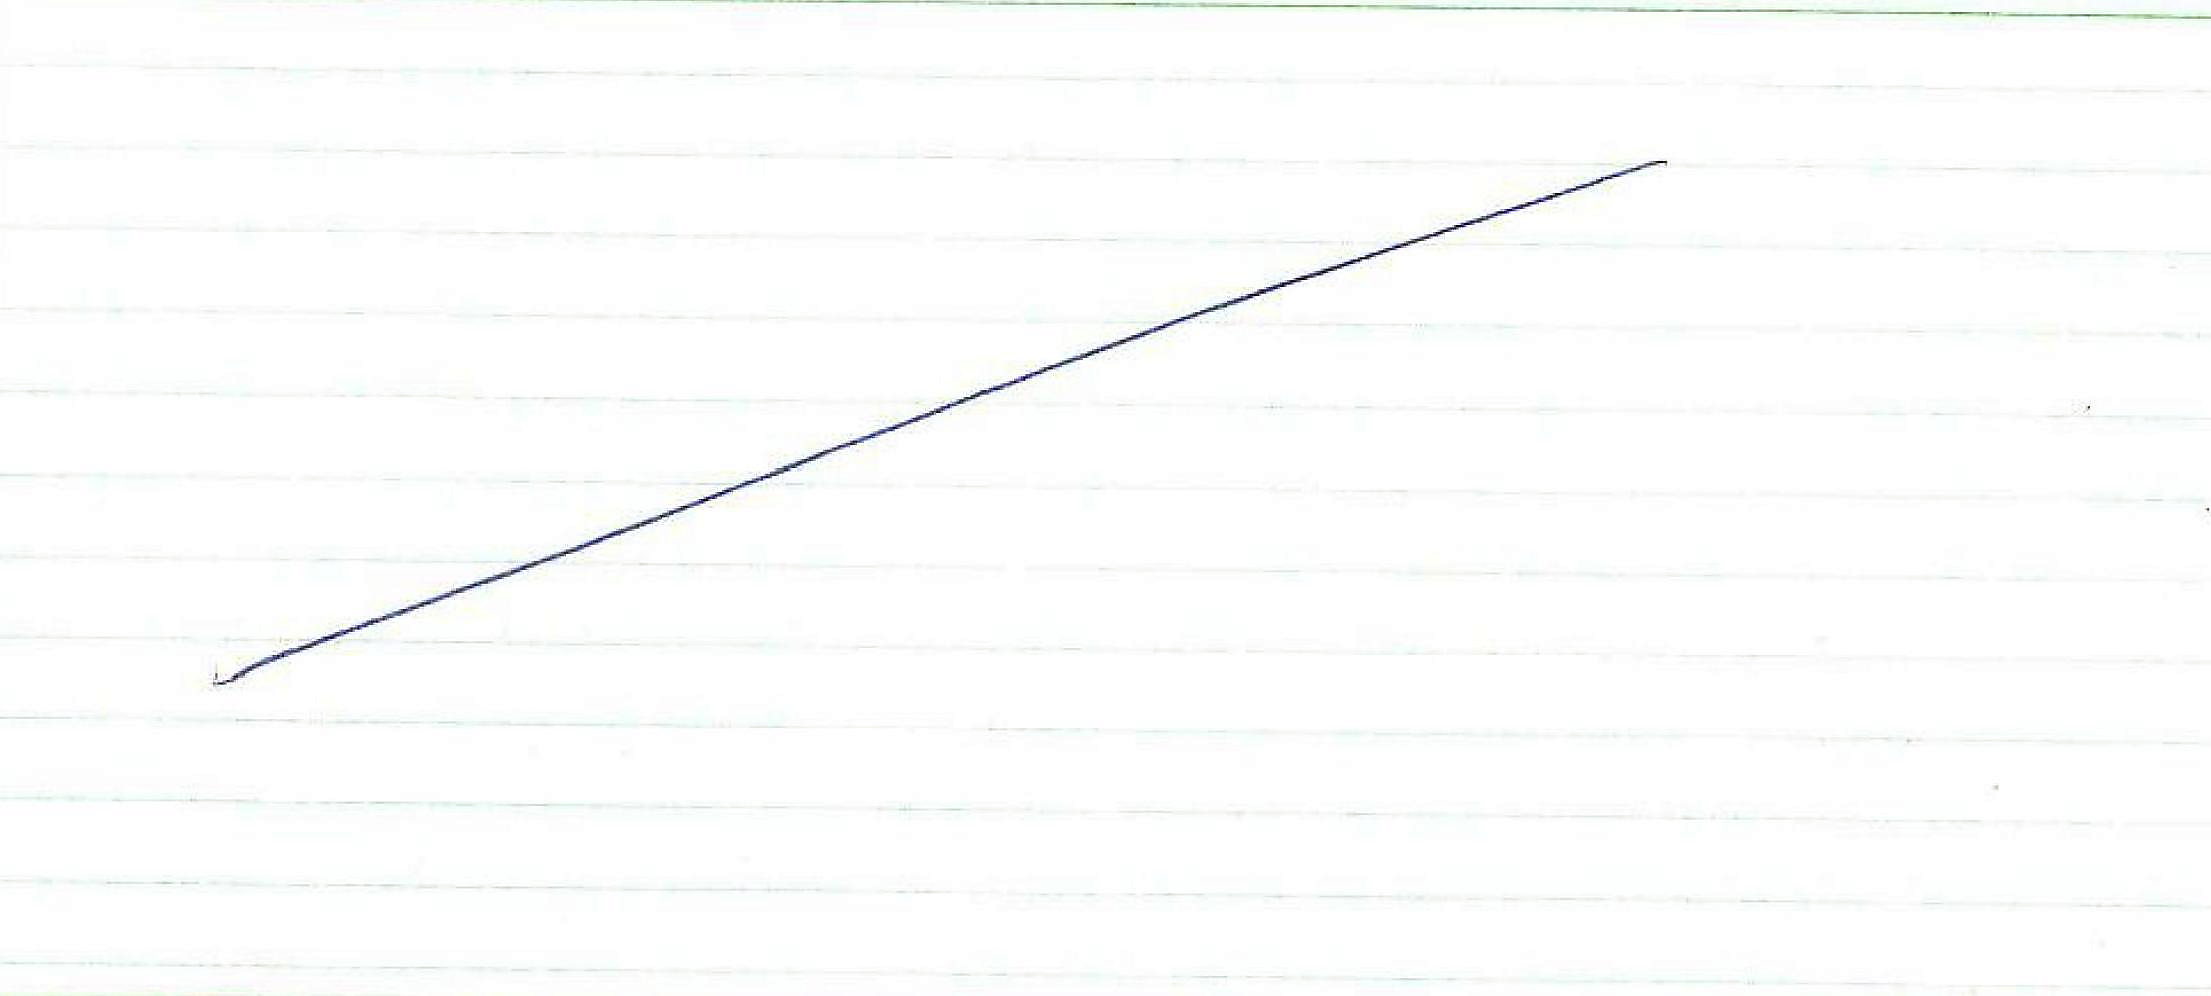

Si l'une des conditions suspensives n'est pas réalisée (sauf renonciation par l'ACQUÉREUR à ces conditions), chacune des parties reprendra sa pleine et entière liberté, sans indemnité de part et d'autre, et la somme remise par l'ACQUÉREUR, à titre d'acompte, lui sera immédiatement restituée, et ceci sans aucune formalité.

## VI - AUTRES CONDITIONS PARTICULIERES (1)

(Notamment, mais sans que cette liste soit exhaustive : plus ample désignation du bien, répartition conventionnelle des charges de copropriété, prise de possession et entrée en jouissance liée à la réalisation d'un événement, et au cas par cas, selon les caractéristiques du bien, objet du présent avant contrat, information relatives à la sécurité des piscines, à la division du terrain...)
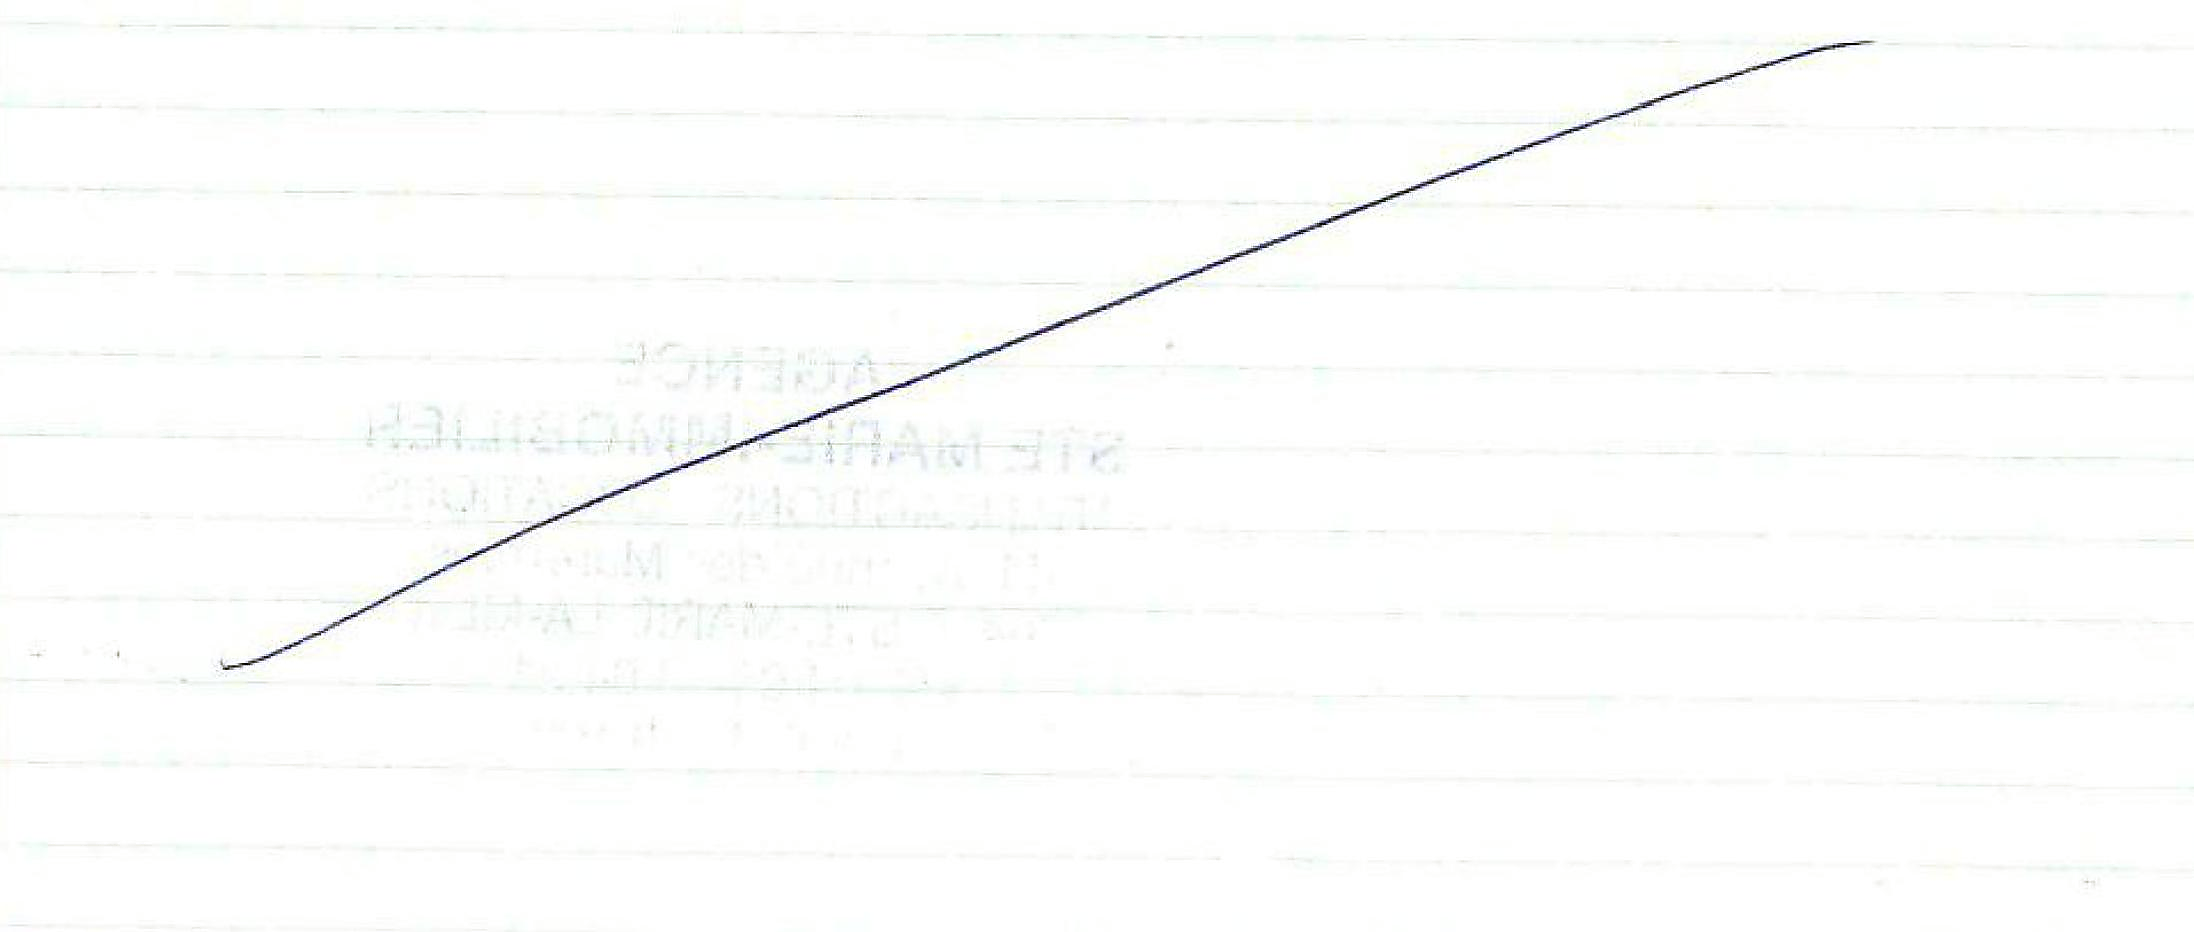
(1) Si l'espace nécessaire au développement des conditions est insuffisant, créer une page bis supplémentaire.

# VII - INTERDICTION AU VENDEUR

Le VENDEUR s'interdit, et ceci jusqu'à la signature de l'acte authentique, d'aliéner à une autre personne que l'ACQUÉREUR les biens vendus quels que soient les avantages qu'il pourra en tirer, l'ACQUÉREUR se réservant le droit de demander en justice l'annulation de tous actes faits en violation des présentes, nonobstant tous dommages et intérêts.

## VIII - RÉALISATION

Les présentes constituent dès leur signature un accord définitif sur la chose et sur le prix, et le VENDEUR ne pourra en aucun cas se refuser à réaliser la vente en se prévalant de l'article 1590 du code civil et en offrant de restituer le double de la somme versée.

L'acte authentique sera établi sur convocation du notaire à la date prévue ci-dessous, sous réserve de l'obtention, par ce dernier, de toutes les pièces, titres et documents nécessaires à la perfection de l'acte.

La signature de l'acte authentique est prévue :

|  ☐ à la date du | 3 mois soit Le 30 Octobre 2025  |
| --- | --- |
|  ☑ dans un délai de |   |
|  Notaire désigné : | Notaire vonaleurs & acquirent  |
|  Maitre Pagnon / SEDES / GOZE / BAGNOULS |   |
|  Notaire à : | Saint Laurent de la Salanque 66250  |
|  Tél : 04 68 28 00 10 | Mail :  |
|  Clerc : |   |
|  éventuellement assisté de : |   |
|  Me |   |
|  Notaire à : |   |
|  Tél : | Mail :  |
|  Clerc : |   |

## IX - CLAUSE PÉNALE

En application de la rubrique "RÉALISATION" et après levée de toutes les conditions suspensives, il est convenu, au cas où l'une des parties viendrait à refuser de régulariser par acte authentique la présente vente dans le délai imparti, qu'elle pourra y être contrainte par tous les moyens et voies de droit, en supportant les frais de poursuites et de recours à justice et sans préjudice de tous dommages et intérêts. Toutefois, la partie qui n'est pas en défaut pourra, à son choix, prendre acte du refus de son co-contractant et invoquer la résolution du contrat.

Dans l'un et l'autre cas, il est expressément convenu que la partie qui n'est pas en défaut percevra de l'autre partie, à titre d'indemnisation forfaitaire de son préjudice, la somme de :

|  Somme en toutes lettres : | Trois mille euros  |
| --- | --- |
|  Somme en chiffres : |   |

De plus, dans l'une et l'autre éventualité, une indemnité compensatrice de sa perte de rémunération restera due au mandataire, dans les conditions de forme prévues ci-après à la rubrique "NÉGOCIATION", l'opération étant définitivement conclue (article 74 du décret 72-678 du 20.07.1972).

## X - NÉGOCIATION

Les parties reconnaissent formellement que le mandataire désigné page 1 les a mis en présence avec le concours éventuel de l'agence :

## AGENCE STE MARIE-IMMOBILIER TRANSACTIONS - LOCATIONS

44, Avenue des Marendes 66470 STE-MARIE-LA-MER Tél. 04 68 73 04 21 Siret : 800 911 018 00011

et a négocié et rédigé les termes, prix et conditions des présentes.

Facultés: 11-15

En conséquence, chacune des parties s'engage à régler audit mandataire dès que l'opération conclue par son intermédiaire aura été constatée par acte authentique, la rémunération ou partie de rémunération prévue à sa charge, figurant au mandat et indiquée ci-après :

à la charge du VENDEUR (ces honoraires seront versés directement par le VENDEUR ou par l'intermédiaire du notaire)

|  mandat n° : | 803 | Onge mille caros soit 1000,00  |
| --- | --- | --- |
|   |  | en date du : 2 juillet 2025  |

à la charge de l'ACQUÉREUR (ces honoraires seront à verser en sus de la même stipulée au paragraphe PAY DE VENTE)

|  mandat n° : | 803 | onge mille caros soit 1000,00  |
| --- | --- | --- |
|   |  | en date du :  |

En cas d'exercice du droit de préemption, les honoraires resteront dus selon les prévisions du mandat : le VENDEUR pour la part prévue à sa charge, le préempteur pour la part prévue à la charge de l'ACQUÉREUR.

### XI - LOI SOLIDARITÉ ET RENOUVELLEMENT URBAINS DU 13 DÉCEMBRE 2000

1. Si le présent compromis sous signature privée n'a pas pour objet l'acquisition d'un immeuble à usage d'habitation ou si l'ACQUÉREUR n'est pas un "NON PROFESSIONNEL", la loi SRU ne s'applique pas et le versement s'effectue dans les formes indiquées ci-après (paragraphe XII "VERSEMENT DE L'ACQUÉREUR - SÉQUESTRE").
2. Si le présent compromis sous signature privée a pour objet l'acquisition d'un immeuble à usage d'habitation par un ACQUÉREUR "NON PROFESSIONNEL", la loi SRU s'applique.
3. Le présent acte est conclu entre deux non-professionnels :
4. **la loi SRU instaure un délai de rétractation** (article L. 271-1 du code de la construction et de l'habitation) de 10 jours à compter du lendemain de la première présentation de la lettre lui notifiant l'acte.
5. Cet acte est notifié à l'ACQUÉREUR par lettre recommandée avec demande d'avis de réception ou par tout autre moyen présentant des garanties équivalentes pour la détermination de la date de réception ou de remise.
6. La faculté de rétractation est exercée dans ces mêmes formes.
7. **la loi SRU interdit tout versement avant l'expiration du délai de rétraction** (article L. 271-2 du code de la construction et de l'habitation reproduit ci-dessous).
8. À l'issue de ce délai, le présent contrat sera soumis à la condition suspensive d'un versement par l'ACQUÉREUR.
9. Ce versement s'effectuera au plus tard jours après l'expiration du délai de rétractation dans les formes indiquées ci-dessous (paragraphe XII "VERSEMENT DE L'ACQUÉREUR - SÉQUESTRE").

Le présent acte est régularisé par l'intermédiaire d'un professionnel (mandataire désigné en page 1) :

- **la loi SRU instaure un délai de rétractation** (article L. 271-1 du code de la construction et de l'habitation) de 10 jours à compter du lendemain de la première présentation de la notification de l'acte faite :
- soit par lettre recommandée avec accusé de réception (AR), ou par tout autre moyen présentant des garanties équivalentes pour la détermination de la date de réception ou de remise ; en cas de pluralité d'acquéreurs, bénéficiant d'un droit de rétractation, domiciliés à la même adresse, ceux-ci se donnent mutuellement procuration pour réceptionner les courriers recommandés leur notifiant la présente ;
- soit par remise en main propre conformément à l'article D. 271-6 du code de la construction et de l'habitation.

Le bénéficiaire du droit de rétractation inscrit de sa main, en page 16 des présentes, les mentions suivantes : "… remis par (nom du professionnel)… à (lieu)… le (date)…" et : "Je déclare avoir connaissance qu'un délai de rétractation de dix jours m'est accordé par l'article L. 271-1 du code de la construction et de l'habitation, et qu'il court à compter du lendemain de la date de remise inscrite de ma main sur le présent acte, soit à compter du …" (article D. 271-6 du CCH).

La faculté de rétractation est exercée par lettre recommandée AR ou par tout autre moyen présentant des garanties équivalentes pour la détermination de la date de réception ou de remise.

- **la loi SRU réglemente le versement au séquestre** (article L. 271-2 du code de la construction et de l'habitation reproduit ci-dessous)

L'ACQUÉREUR effectue un versement entre les mains d'un professionnel disposant d'une garantie financière affectée au remboursement des fonds déposés dans les formes indiquées ci-dessous (paragraphe XII "VERSEMENT DE L'ACQUÉREUR - SÉQUESTRE"). Si l'ACQUÉREUR décide de renoncer au présent compromis de vente pendant le délai de rétractation, le séquestre devra lui restituer le dépôt sous 21 jours à compter du lendemain de la date de cette rétractation.

Page 15

# XIV - AFFIRMATION DE SINCÉRITÉ

La partie ayant un doute sur l'étendue du pouvoir d'un des représentants signataires aux présentes pourra, préalablement à la signature de la promesse, demander par écrit ou représenté de lui confirmer l'habilitation du représentant tel que prévu par l'article 1158 du code civil.

Les parties soussignées affirment, sous les peines édictées par l'article 1837 du code général des impôts, que le présent engagement exprime l'intégralité du prix convenu.

Par ailleurs, l'ACQUÉREUR déclare effectuer le paiement du prix de vente et, des éventuels honoraires, au moyen de ses fonds propres, et, le cas échéant, de concours bancaires.

Conformément aux articles L. 561-1 et suivants du code monétaire et financier, l'acquéreur déclare que l'opération envisagée aux termes des présentes n'est pas liée au blanchiment de capitaux ou au financement du terrorisme.

# XV - ACTION EN NULLITÉ

L'une des parties pourra demander à la partie pouvant se prévaloir d'une nullité au contrat, de confirmer celui-ci ou d'agir en nullité dans un délai de six mois. Passé ce délai le contrat sera réputé confirmé.

Au moment de la demande, la cause de la nullité doit avoir cessé et respectera les conditions visées à l'article 1183 du code civil.

Ladite action ne pourra être invoquée que pour une violation de la sauvegarde d'un intérêt privé propre à l'une des parties.

# XVI - SIGNATURE(S) DES PARTIES

|  **BAYES NUIS** | **Fait à** Sanche Lucie lafler le 30 Juillet 2025  |
| --- | --- |
|  **mots** | **en autant d'originoux qu'il y a de parties.**  |
|  **Personnes** | **Le VENDEUR**  |
|   | **Date et signature(s) précédée(s) de la mention manuscrite**  |
|   | **"Lu et approuvé - Bon pour accord"**  |
|   | **"Lu et approuvé - Bon pour accord"**  |

Le 29 Juillet 2025

Le 29 Juillet 2025

Le 29 Juillet 2025

Le 29 Juillet 2025

Le 29 Juillet 2025

Le 29 Juillet 2025

Le 29 Juillet 2025

Le 29 Juillet 2025

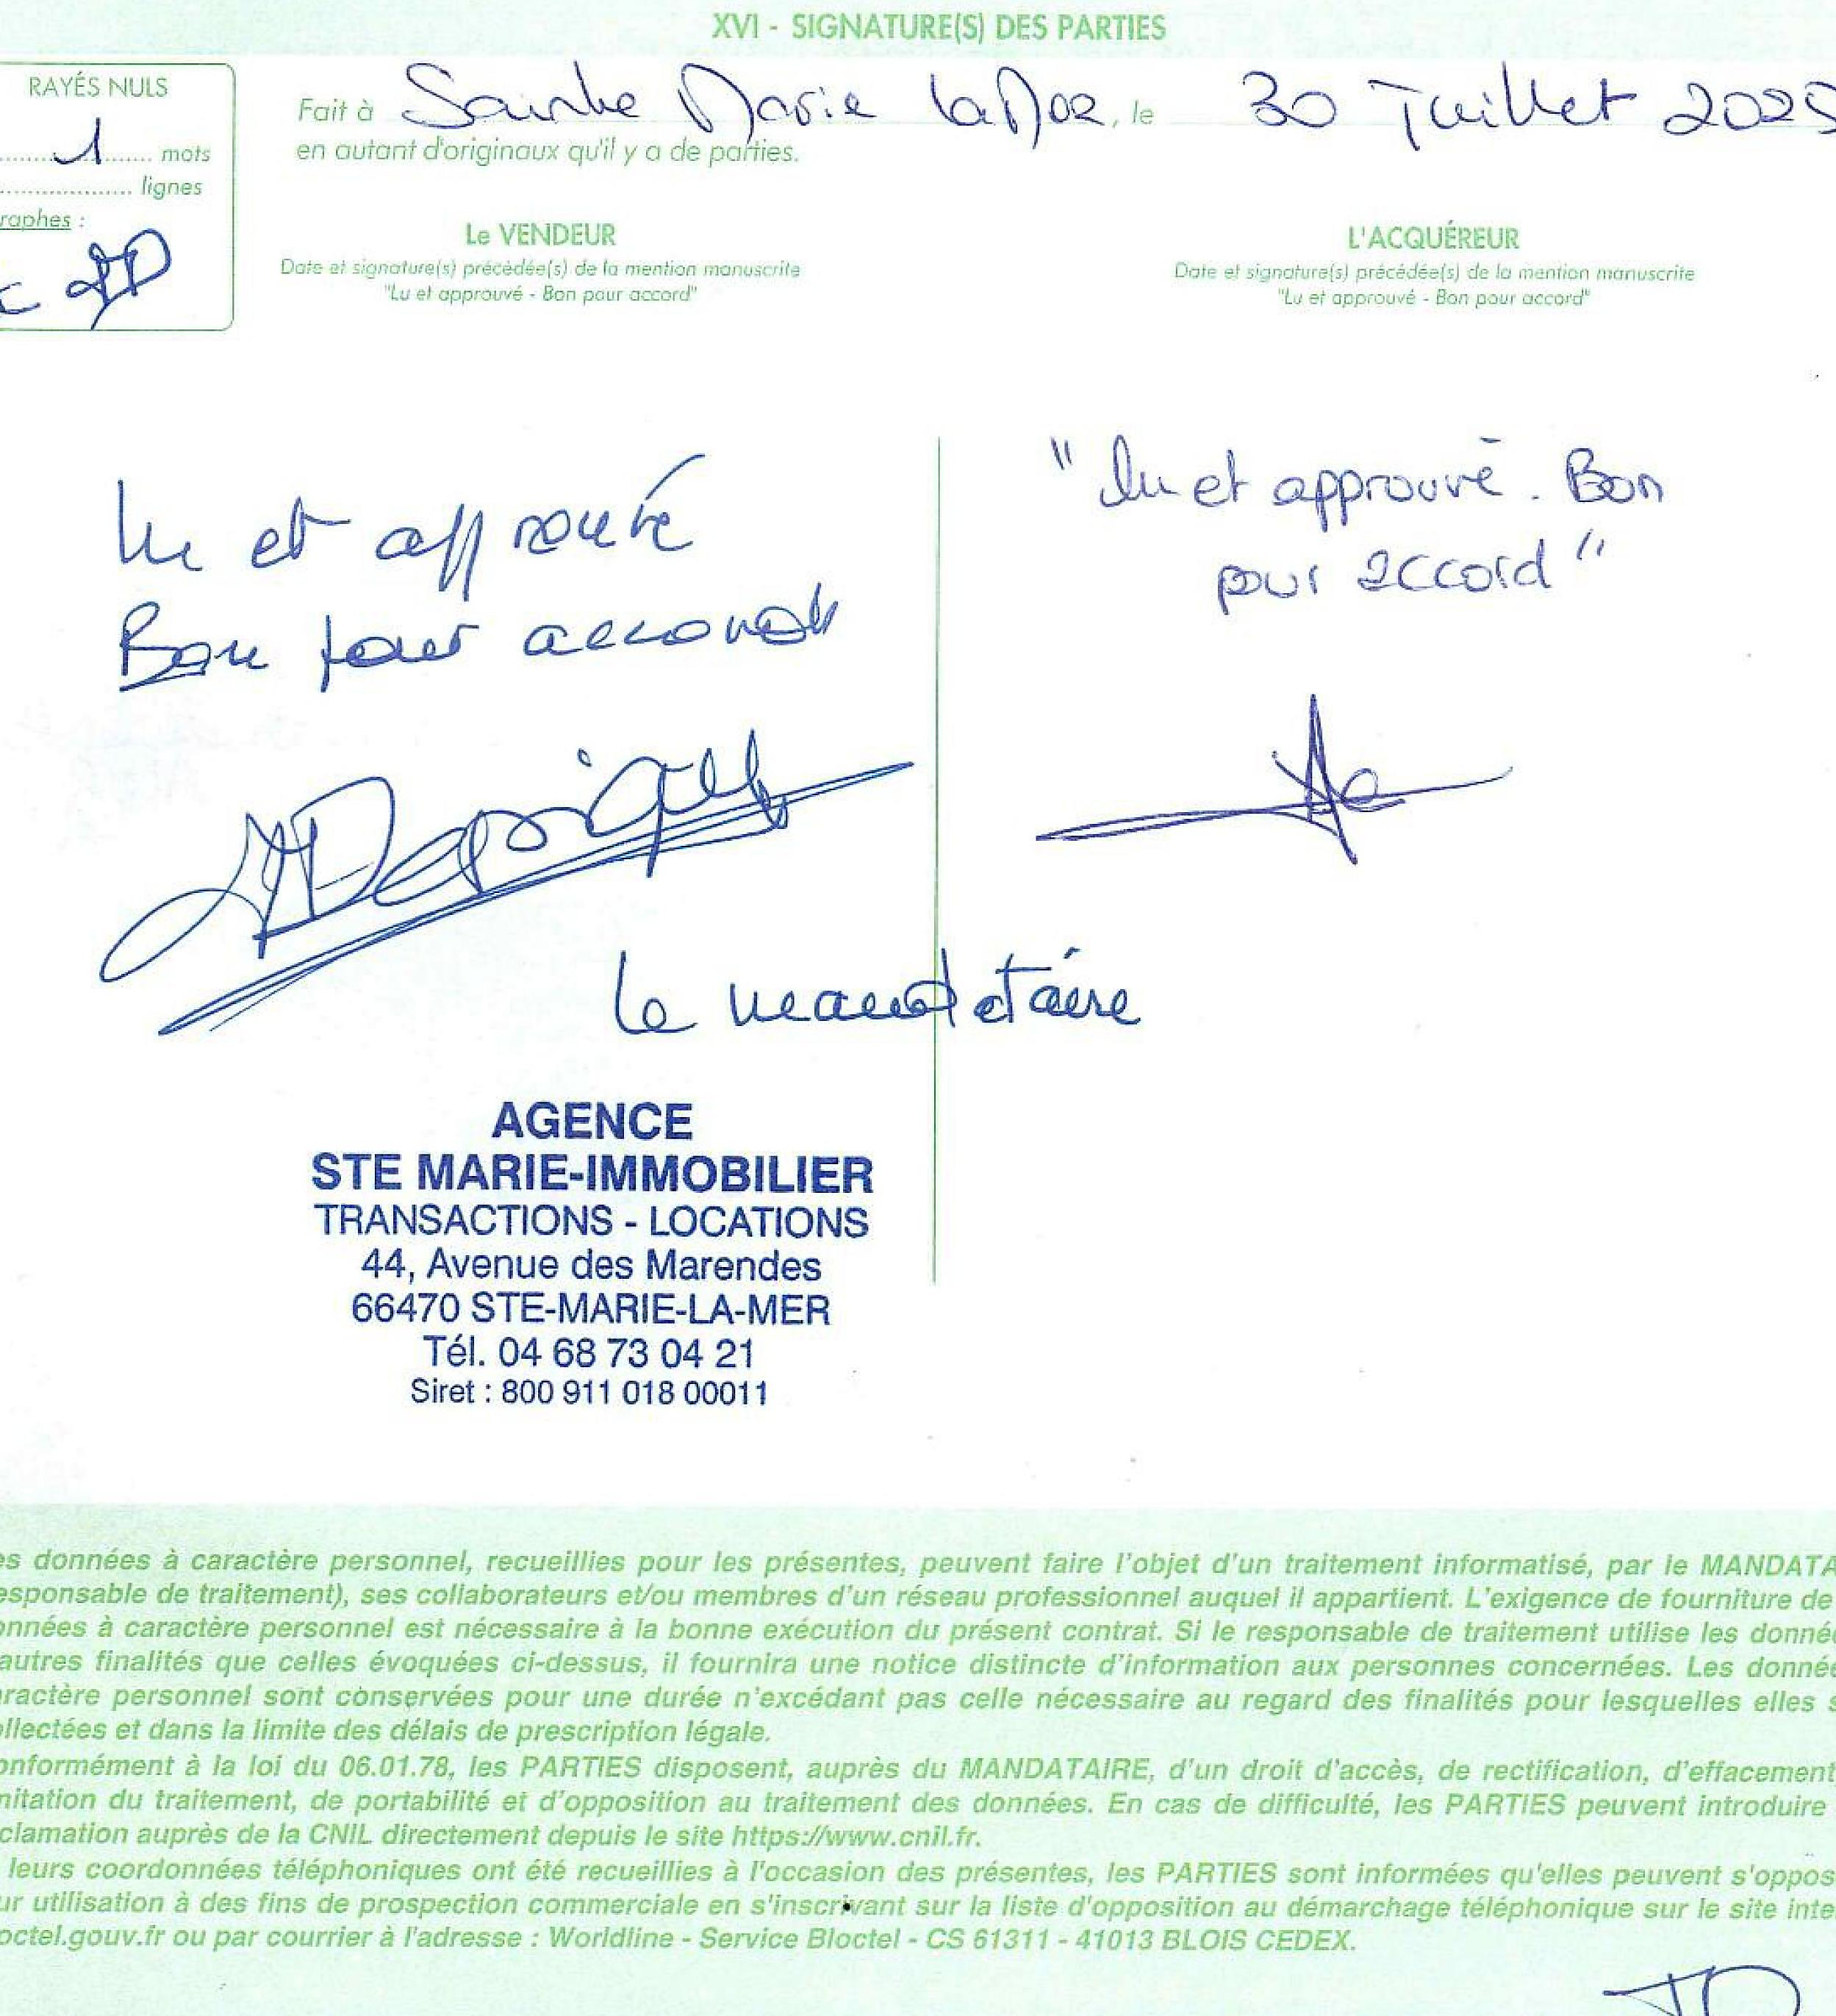

In [12]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display
from pathlib import Path
import re, base64, io, hashlib

# --- Déps images (optionnelles et en fallback propre) ---
try:
    import cv2
except Exception:
    cv2 = None

try:
    from PIL import Image, ImageOps, ImageFilter
except Exception:
    Image = None
    ImageOps = None
    ImageFilter = None

# ===================== OPTIONS =====================
# ORIGINAL_PDF_PATH = r"C:\Users\...\mon_document.pdf"

# Prévisualisation de pages aplaties avec annotations visibles
PREVIEW_ANNOTATED_PAGES = True
MAX_PREVIEW_PAGES = 5
PREVIEW_DPI = 220

# Inclure des vignettes "crops" des signatures (widgets Sig + annotations Ink)
INCLUDE_SIGNATURE_CROPS = True
MAX_SIGNATURE_CROPS = 6
SIGN_CROP_DPI = 300
SIGN_CROP_MARGIN_PT = 6  # marge autour de la signature (points PDF)

# >>> Améliorations qualité <<<
# Traiter les images intégrées retournées par l'OCR (pour meilleure lisibilité)
ENHANCE_EMBEDDED_IMAGES = True
# Traiter les vignettes de signatures (crops)
ENHANCE_SIGNATURE_CROPS = True

# Pipeline qualité (si OpenCV dispo, on l’utilise; sinon on fait du PIL)
IMG_CLAHE = True           # contraste adaptatif
IMG_DENOISE = True         # débruitage léger
IMG_UNSHARP = True         # netteté
IMG_DEGLARE = True         # atténuation “flash” (zones très blanches)
IMG_SHADOW_NORM = True     # normalisation d’éclairage
# ===================================================


# ---------------- Utilitaires base64 / images ----------------
def _strip_data_url_prefix(s: str) -> str:
    """Retire 'data:image/...;base64,' si présent."""
    if not s:
        return s
    if s.startswith("data:"):
        prefix_end = s.find("base64,")
        if prefix_end != -1:
            return s[prefix_end+7:]
    return s

def _pil_from_b64(b64_or_dataurl: str):
    if Image is None:
        return None
    raw_b64 = _strip_data_url_prefix(b64_or_dataurl)
    try:
        return Image.open(io.BytesIO(base64.b64decode(raw_b64))).convert("RGB")
    except Exception:
        return None

def _pil_to_data_url(pil_img, mime="image/png") -> str:
    if Image is None or pil_img is None:
        return ""
    buf = io.BytesIO()
    pil_img.save(buf, format="PNG", optimize=True)
    return f"data:{mime};base64," + base64.b64encode(buf.getvalue()).decode("ascii")

def _pil_exif_autorotate(im):
    if ImageOps is None:
        return im
    try:
        return ImageOps.exif_transpose(im)
    except Exception:
        return im

def _cv_from_pil(img):
    # PIL RGB -> cv2 BGR
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def _pil_from_cv(img_bgr):
    # cv2 BGR -> PIL RGB
    return Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))


# ----------- Petit pipeline qualité pour une PIL Image -----------
# (fallback PIL si cv2 indisponible)
import numpy as np

def _enhance_pil_for_display(pil_img):
    if pil_img is None:
        return None

    # Rotation EXIF
    pil_img = _pil_exif_autorotate(pil_img)

    # Si pas de cv2, fallback PIL (contrast + sharpen légers)
    if cv2 is None:
        if ImageOps is not None:
            pil_img = ImageOps.autocontrast(pil_img)
        if ImageFilter is not None and IMG_UNSHARP:
            pil_img = pil_img.filter(ImageFilter.UnsharpMask(radius=1, percent=120, threshold=3))
        return pil_img

    # OpenCV pipeline (plus robuste)
    bgr = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Dé-glare (flash)
    if IMG_DEGLARE:
        _, mask = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY)
        if mask.mean() >= 1:
            bgr = cv2.inpaint(bgr, mask, 3, cv2.INPAINT_TELEA)
            gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Normalisation d’éclairage (ombres)
    if IMG_SHADOW_NORM:
        try:
            dilated = cv2.dilate(gray, np.ones((15,15), np.uint8))
            bg = cv2.medianBlur(dilated, 35)
            gray = cv2.divide(gray, bg, scale=255)
            bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        except Exception:
            pass

    # CLAHE sur la luminance
    if IMG_CLAHE:
        ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        y = clahe.apply(y)
        bgr = cv2.cvtColor(cv2.merge([y, cr, cb]), cv2.COLOR_YCrCb2BGR)

    # Denoise léger
    if IMG_DENOISE:
        bgr = cv2.fastNlMeansDenoisingColored(bgr, None, 8, 8, 7, 21)

    # Unsharp (sur Y)
    if IMG_UNSHARP:
        ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        y_blur = cv2.GaussianBlur(y, (3,3), 0)
        y_sharp = cv2.addWeighted(y, 1.2, y_blur, -0.2, 0)
        bgr = cv2.cvtColor(cv2.merge([y_sharp, cr, cb]), cv2.COLOR_YCrCb2BGR)

    return Image.fromarray(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))


def _enhance_data_url(data_or_b64: str) -> str:
    """Decode -> enhance -> re-encode data URL. Fallback gracieux si erreurs."""
    if not ENHANCE_EMBEDDED_IMAGES:
        return _to_data_url(data_or_b64)
    pil = _pil_from_b64(data_or_b64)
    if pil is None:
        return _to_data_url(data_or_b64)
    pil2 = _enhance_pil_for_display(pil)
    if pil2 is None:
        return _to_data_url(data_or_b64)
    return _pil_to_data_url(pil2)


def _enhance_data_url_for_signature(data_or_b64: str) -> str:
    """Spécifique pour les crops de signature (un poil plus agressif)."""
    if not ENHANCE_SIGNATURE_CROPS:
        return data_or_b64 if data_or_b64.startswith("data:") else _to_data_url(data_or_b64)
    pil = _pil_from_b64(data_or_b64)
    if pil is None:
        return data_or_b64 if data_or_b64.startswith("data:") else _to_data_url(data_or_b64)

    # Accentuer un peu plus
    if cv2 is None:
        if ImageOps is not None:
            pil = ImageOps.autocontrast(pil)
        if ImageFilter is not None:
            pil = pil.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=2))
        return _pil_to_data_url(pil)

    bgr = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Renforcer contraste + léger seuillage adaptatif pour traits stylo
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 35, 5)
    # petit débruitage morpho
    bw = cv2.medianBlur(bw, 3)

    # Repasser en RGB 3 canaux (pour compatibilité)
    bgr2 = cv2.cvtColor(bw, cv2.COLOR_GRAY2BGR)
    pil2 = Image.fromarray(cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB))
    return _pil_to_data_url(pil2)


def _to_data_url(b64: str, default_mime: str = "image/png") -> str:
    """Assure un data URL valide pour les images (si l'OCR retourne du base64 brut)."""
    if not b64:
        return b64
    return b64 if b64.startswith("data:") else f"data:{default_mime};base64,{b64}"

def _clean_markdown(md: str) -> str:
    lines = md.splitlines()
    out = []
    prev_blank = False
    for line in lines:
        blank = (line.strip() == "")
        if blank and prev_blank:
            continue
        out.append(line.rstrip())
        prev_blank = blank
    return "\n".join(out).strip()


# ---------------- Détails signatures numériques ----------------
def _try_signature_details_with_pyhanko(pdf: Path):
    try:
        from pyhanko.pdf_utils.reader import PdfFileReader
        from pyhanko.sign.validation import ValidationContext, validate_pdf_signature
    except Exception:
        return None, []
    lines = []
    try:
        with open(pdf, "rb") as fh:
            r = PdfFileReader(fh)
            sigs = getattr(r, "embedded_signatures", [])
            header = f"**Signatures numériques détectées (pyHanko)** : {len(sigs)}"
            if not sigs:
                return header, ["_Aucune signature numérique détectée._"]
            vc = ValidationContext(allow_fetching=False)
            for idx, sig in enumerate(sigs, start=1):
                field_name = getattr(sig, "field_name", "(champ inconnu)")
                try:
                    status = validate_pdf_signature(sig, vc)
                    summ = status.summary()
                except Exception as e:
                    summ = f"Validation non effectuée ({e})"
                try:
                    subf = getattr(sig, "sig_object", None)
                    subf = getattr(subf, "subfilter", b"")
                    subf = subf.decode("utf-8") if isinstance(subf, (bytes, bytearray)) else str(subf)
                except Exception:
                    subf = "inconnu"
                lines.append(f"- #{idx} • champ **{field_name}** • sous-filtre: `{subf}` • {summ}")
            return header, lines
    except Exception:
        return None, []


# ---------------- Rendu pages annotées ----------------
def _render_annotated_previews(pdf: Path, dpi: int = 220, max_pages: int = 5):
    try:
        import fitz  # PyMuPDF
    except Exception:
        return []
    try:
        doc = fitz.open(str(pdf))
        zoom = dpi / 72.0
        mat = fitz.Matrix(zoom, zoom)
        data_urls = []
        for i, page in enumerate(doc, start=1):
            if len(data_urls) >= max_pages:
                break
            pix = page.get_pixmap(matrix=mat, annots=True, alpha=False)
            png_bytes = pix.tobytes("png")
            b64 = base64.b64encode(png_bytes).decode("ascii")
            data_urls.append(f"data:image/png;base64,{b64}")
        doc.close()
        return data_urls
    except Exception:
        return []


# ---------------- Crops de signatures (widgets + Ink) ----------------
def _extract_signature_crops(pdf: Path, dpi: int = 300, margin_pt: float = 6.0, max_crops: int = 6):
    """
    Extrait des vignettes (PNG base64) des signatures visibles :
    - widgets de type Signature
    - annotations 'Ink' (stylo)
    """
    try:
        import fitz  # PyMuPDF
    except Exception:
        return []

    crops = []
    try:
        doc = fitz.open(str(pdf))
        zoom = dpi / 72.0
        mat = fitz.Matrix(zoom, zoom)
        for p_idx, page in enumerate(doc, start=1):
            if len(crops) >= max_crops:
                break

            # 1) Widgets de signature
            widgets = page.widgets() or []
            for w in widgets:
                if len(crops) >= max_crops:
                    break
                wtype_str = (getattr(w, "field_type_string", "") or str(getattr(w, "field_type", ""))).upper()
                name = (getattr(w, "field_name", "") or "").lower()
                if ("SIGNATURE" in wtype_str) or ("SIG" in wtype_str) or ("sign" in name):
                    rect = fitz.Rect(w.rect)
                    rect = rect + fitz.Rect(-margin_pt, -margin_pt, margin_pt, margin_pt)
                    rect = rect & page.rect  # clamp
                    if rect.is_empty or rect.width < 5 or rect.height < 5:
                        continue
                    pix = page.get_pixmap(matrix=mat, annots=True, alpha=False, clip=rect)
                    png_bytes = pix.tobytes("png")
                    b64 = base64.b64encode(png_bytes).decode("ascii")
                    crops.append((p_idx, f"data:image/png;base64,{b64}"))

            # 2) Annotations Ink (stylo)
            annots = page.annots()
            if annots:
                for a in annots:
                    if len(crops) >= max_crops:
                        break
                    try:
                        t = a.type
                        a_type = t[1] if isinstance(t, tuple) and len(t) > 1 else str(t)
                    except Exception:
                        a_type = ""
                    if "INK" in a_type.upper():
                        rect = fitz.Rect(a.rect)
                        if rect.width < 10 or rect.height < 10:
                            continue
                        rect = rect + fitz.Rect(-margin_pt, -margin_pt, margin_pt, margin_pt)
                        rect = rect & page.rect
                        pix = page.get_pixmap(matrix=mat, annots=True, alpha=False, clip=rect)
                        png_bytes = pix.tobytes("png")
                        b64 = base64.b64encode(png_bytes).decode("ascii")
                        crops.append((p_idx, f"data:image/png;base64,{b64}"))

        doc.close()

        # Déduplication (évite doublons visuels)
        seen = set()
        dedup = []
        for (pno, dataurl) in crops:
            h = hashlib.md5(dataurl.encode("utf-8")).hexdigest()
            if h in seen:
                continue
            seen.add(h)
            # Amélioration dédiée signature si demandé
            dataurl2 = _enhance_data_url_for_signature(dataurl)
            dedup.append((pno, dataurl2))
        return dedup

    except Exception:
        return []


# ---------------- Contexte PDF : meta, signatures, annotations, cases ----------------
def _try_extract_pdf_context() -> str:
    pdf_path = globals().get("ORIGINAL_PDF_PATH", None)
    if not pdf_path:
        return ""
    pdf = Path(pdf_path)
    if not pdf.is_file():
        return ""

    # Partie PyMuPDF (meta, annotations, formulaires)
    try:
        import fitz  # PyMuPDF
    except Exception as e:
        base_md = f"<!-- Contexte PDF ignoré (PyMuPDF non installé: {e}) -->"
        sig_header, sig_detail = _try_signature_details_with_pyhanko(pdf)
        if sig_header:
            md = ["## Contexte du PDF", "### Signatures", sig_header, *sig_detail]
            return _clean_markdown("\n".join(md) + "\n\n" + base_md)
        return base_md

    try:
        doc = fitz.open(str(pdf))
        meta = doc.metadata or {}
        meta_keys = ("title", "author", "subject", "keywords", "creator",
                     "producer", "creationDate", "modDate")
        meta_lines = []
        for k in meta_keys:
            v = meta.get(k) or meta.get(k.capitalize())
            if v:
                meta_lines.append(f"- **{k}** : {v}")
        if not meta_lines:
            meta_lines.append("_Aucune métadonnée standard trouvée._")

        ann_lines = []
        ink_detected = False
        for p_idx, page in enumerate(doc, start=1):
            annots = page.annots()
            if not annots:
                continue
            for a in annots:
                a_type = ""
                try:
                    t = a.type
                    a_type = t[1] if isinstance(t, tuple) and len(t) > 1 else str(t)
                except Exception:
                    a_type = "Annotation"
                if "INK" in a_type.upper():
                    ink_detected = True
                info = getattr(a, "info", {}) or {}
                content = info.get("content") or info.get("subject") or ""
                ann_lines.append(f"- p.{p_idx} • {a_type}" + (f" • {content}" if content else ""))

        if not ann_lines:
            ann_lines = ["_Aucune annotation détectée._"]

        cb_lines = []
        sig_form_lines = []
        for p_idx, page in enumerate(doc, start=1):
            widgets = page.widgets()
            if not widgets:
                continue
            for w in widgets:
                wtype_str = getattr(w, "field_type_string", None)
                if not wtype_str:
                    wtype_str = str(getattr(w, "field_type", ""))
                name = getattr(w, "field_name", "") or "(champ)"
                val = getattr(w, "field_value", "")
                ws = (wtype_str or "").upper()
                if "CHECKBOX" in ws or ("BUTTON" in ws and "CHECK" in ws):
                    state = str(val).lower()
                    checked = state in ("yes", "on", "true", "1")
                    cb_lines.append(f"- p.{p_idx} • {name} : {'cochée' if checked else 'décochée'}")
                elif "SIGNATURE" in ws or "SIG" in ws or "SIGN" in name.lower():
                    sig_form_lines.append(f"- p.{p_idx} • champ de signature : {name}")

        if not cb_lines:
            cb_lines = ["_Aucun champ de formulaire (cases) détecté._"]

        has_sig_flag = False
        try:
            has_sig_flag = bool(getattr(doc, "has_signatures", False))
        except Exception:
            has_sig_flag = False

        sig_header_hanko, sig_lines_hanko = _try_signature_details_with_pyhanko(pdf)
        doc.close()

        parts = []
        parts.append("## Contexte du PDF")
        parts.append("### Métadonnées")
        parts.extend(meta_lines)

        parts.append("\n### Signatures")
        if sig_header_hanko:
            parts.append(sig_header_hanko)
            parts.extend(sig_lines_hanko)
        else:
            sig_header = f"**Champs de signature détectés** : {len(sig_form_lines)}"
            if has_sig_flag:
                sig_header += " — Le document contient des signatures numériques (non validées ici)."
            parts.append(sig_header)
            if sig_form_lines:
                parts.extend(sig_form_lines)
            else:
                parts.append("_Aucun champ de signature détecté._")

        parts.append("\n### Annotations (non rendues par l’OCR)")
        parts.extend(ann_lines)
        parts.append("\n### Cases à cocher / champs de formulaire")
        parts.extend(cb_lines)

        globals()["_PDF__HAS_INK"] = ink_detected
        return _clean_markdown("\n".join(parts))

    except Exception as e:
        return f"<!-- Contexte PDF ignoré (erreur d'extraction: {e}) -->"


# ---------------- Remplacement des images OCR par data URLs (avec amélioration) ----------------
def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    """
    Replace image placeholders in markdown with base64-encoded images.
    """
    if not images_dict:
        return markdown_str

    # Remplacement robuste: ![alt](img_id) -> ![alt](data:<mime>;base64,...)
    pattern = re.compile(r'!\[([^\]]*)\]\(([^)]+)\)')
    def _repl(m):
        alt, target = m.group(1), m.group(2)
        # id peut être dans (target) ou dans (alt)
        b64 = images_dict.get(target) or images_dict.get(alt)
        if b64:
            # Amélioration qualité des images embarquées si demandé
            data_url = _enhance_data_url(b64) if ENHANCE_EMBEDDED_IMAGES else _to_data_url(b64)
            return f"![{alt}]({data_url})"
        return m.group(0)

    return pattern.sub(_repl, markdown_str)


# ---------------- Assemblage final ----------------
def get_combined_markdown(ocr_response: OCRResponse) -> str:
    """
    Combine OCR text and images into a single markdown document.
    """
    sections: list[str] = []

    # 1) Contexte du PDF
    ctx = _try_extract_pdf_context()
    if ctx:
        sections.append(ctx)

    # 2) OCR page par page
    markdowns: list[str] = []
    for page in getattr(ocr_response, "pages", []) or []:
        image_data = {}
        for img in getattr(page, "images", []) or []:
            img_id = getattr(img, "id", None)
            img_b64 = getattr(img, "image_base64", None)
            if img_id and img_b64:
                image_data[img_id] = img_b64
        page_md = getattr(page, "markdown", "") or ""
        page_md = replace_images_in_markdown(page_md, image_data)
        page_md = _clean_markdown(page_md)
        if page_md:
            markdowns.append(page_md)

    if markdowns:
        sections.append("\n\n".join(markdowns))

    # 3) (Optionnel) Extraits de signatures (crops)
    pdf_path = globals().get("ORIGINAL_PDF_PATH", None)
    if INCLUDE_SIGNATURE_CROPS and pdf_path:
        pdfp = Path(pdf_path)
        if pdfp.is_file():
            crops = _extract_signature_crops(pdfp, dpi=SIGN_CROP_DPI, margin_pt=SIGN_CROP_MARGIN_PT, max_crops=MAX_SIGNATURE_CROPS)
            if crops:
                sec = ["\n## Extraits de signatures (aperçus)"]
                for (pno, data_url) in crops:
                    sec.append(f"**Page {pno}**\n\n![signature p{pno}]({data_url})")
                sections.append("\n\n".join(sec))

    # 4) (Optionnel) Aperçu des pages avec annotations visibles
    ink_seen = globals().get("_PDF__HAS_INK", False)
    if PREVIEW_ANNOTATED_PAGES and pdf_path and ink_seen:
        pdfp = Path(pdf_path)
        if pdfp.is_file():
            previews = _render_annotated_previews(pdfp, dpi=PREVIEW_DPI, max_pages=MAX_PREVIEW_PAGES)
            if previews:
                sec = ["\n## Aperçu des pages (annotations visibles)"]
                for i, data_url in enumerate(previews, start=1):
                    sec.append(f"**Page {i}**\n\n![page {i}]({data_url})")
                sections.append("\n\n".join(sec))

    return _clean_markdown("\n\n".join(sections))


# ---- Affichage final ----
display(Markdown(get_combined_markdown(pdf_response)))


## Mistral OCR with Image

In addition to the PDF file shown above, Mistral OCR can also process image files:

In [96]:
from pathlib import Path
from PIL import Image, ImageOps
import re

def concat_images(
    source,
    orientation: str = "vertical",     # "vertical" ou "horizontal"
    recursive: bool = False,           # True = parcours des sous-dossiers si source est un dossier
    exts = (".png", ".jpg", ".jpeg", ".webp", ".bmp", ".tif", ".tiff"),
    resize: str = "fit",               # "fit" (homogénéise la dimension dominante) ou "none" (pas de redimensionnement, padding)
    spacing: int = 0,                  # espace (px) entre images
    bg=(255, 255, 255),                # couleur de fond (RGB) pour padding / aplatissement alpha
    out_path: str | Path | None = None # si fourni, sauvegarde l'image finale
):
    """
    Concatène plusieurs images en une seule.

    - source : dossier (str/Path) OU liste de chemins d'images (str/Path).
    - orientation : "vertical" (pile) ou "horizontal" (ligne).
    - recursive : si source est un dossier, inclut les sous-dossiers.
    - exts : extensions acceptées (en minuscules).
    - resize :
        * "fit"  : met toutes les images à la même largeur (vertical) ou même hauteur (horizontal), en conservant l'aspect.
        * "none" : ne redimensionne pas; pad avec la couleur bg pour aligner.
    - spacing : pixels d'espace entre deux images.
    - bg : couleur de fond (RGB).
    - out_path : chemin de sauvegarde optionnel.
    Retourne : PIL.Image.Image (l'image concaténée).
    """
    # ---- Collecte des chemins ----
    if isinstance(source, (str, Path)):
        folder = Path(source)
        if not folder.is_dir():
            raise ValueError("source est un chemin : il doit pointer vers un dossier. Sinon passez une liste de fichiers.")
        pattern = "**/*" if recursive else "*"
        paths = [p for p in folder.glob(pattern) if p.is_file() and p.suffix.lower() in exts]
    else:
        paths = [Path(p) for p in source]

    if not paths:
        raise ValueError("Aucune image trouvée.")

    # Tri naturel (page1, page2, page10…)
    def _natural_key(p: Path):
        s = p.name.lower()
        return [int(t) if t.isdigit() else t for t in re.split(r"(\d+)", s)]
    paths = sorted(paths, key=_natural_key)

    # ---- Ouverture & normalisation de base ----
    imgs = []
    for p in paths:
        im = Image.open(p)
        # Respect orientation EXIF
        try:
            im = ImageOps.exif_transpose(im)
        except Exception:
            pass
        # Aplatir l'alpha sur fond bg
        if im.mode in ("RGBA", "LA"):
            base = Image.new("RGB", im.size, bg)
            base.paste(im, mask=im.split()[-1])
            im = base
        else:
            im = im.convert("RGB")
        imgs.append(im)

    # ---- Redimensionnement / Padding ----
    if orientation.lower() == "vertical":
        if resize == "fit":
            target_w = max(im.width for im in imgs)
            resized = [
                (im if im.width == target_w else im.resize((target_w, int(round(im.height * target_w / im.width))), Image.LANCZOS))
                for im in imgs
            ]
        else:  # "none" => on pad à la largeur max
            target_w = max(im.width for im in imgs)
            resized = []
            for im in imgs:
                if im.width == target_w:
                    resized.append(im)
                else:
                    canvas = Image.new("RGB", (target_w, im.height), bg)
                    x = (target_w - im.width) // 2
                    canvas.paste(im, (x, 0))
                    resized.append(canvas)

        total_h = sum(im.height for im in resized) + spacing * (len(resized) - 1)
        canvas = Image.new("RGB", (target_w, total_h), bg)
        y = 0
        for im in resized:
            canvas.paste(im, (0, y))
            y += im.height + spacing

    elif orientation.lower() == "horizontal":
        if resize == "fit":
            target_h = max(im.height for im in imgs)
            resized = [
                (im if im.height == target_h else im.resize((int(round(im.width * target_h / im.height)), target_h), Image.LANCZOS))
                for im in imgs
            ]
        else:  # "none" => on pad à la hauteur max
            target_h = max(im.height for im in imgs)
            resized = []
            for im in imgs:
                if im.height == target_h:
                    resized.append(im)
                else:
                    canvas = Image.new("RGB", (im.width, target_h), bg)
                    y = (target_h - im.height) // 2
                    canvas.paste(im, (0, y))
                    resized.append(canvas)

        total_w = sum(im.width for im in resized) + spacing * (len(resized) - 1)
        canvas = Image.new("RGB", (total_w, target_h), bg)
        x = 0
        for im in resized:
            canvas.paste(im, (x, 0))
            x += im.width + spacing
    else:
        raise ValueError("orientation doit être 'vertical' ou 'horizontal'.")

    # ---- Sauvegarde optionnelle ----
    if out_path:
        out_path = Path(out_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        canvas.save(out_path)

    return canvas


In [99]:
final_img = concat_images(r"C:/Users/aliou/OneDrive/Desktop/Mes projets/document_OCR_LLM/image", orientation="vertical", recursive=False, spacing=8, out_path="C:/Users/aliou/OneDrive/Desktop/Mes projets/document_OCR_LLM/image/concat.png")


In [ ]:

import base64, io
from pathlib import Path

# Import robuste pour ImageURLChunk (au cas où)
try:
    from mistralai import ImageURLChunk
except Exception:
    from mistralai.models import ImageURLChunk

# Dépendances imagerie (fallback propre si absentes)
try:
    from PIL import Image, ImageOps, ImageFilter
except Exception:
    Image = None
    ImageOps = None
    ImageFilter = None

try:
    import cv2, numpy as np
except Exception:
    cv2 = None

# Verify image exists locally
#image_file = Path(r"C:/Users/aliou/OneDrive/Desktop/Mes projets/document_OCR_LLM/AVIS-IMPOT-ANSELME-REV-2023.jpg")
image_file=  Path(r"C:/Users/aliou/OneDrive/Desktop/Mes projets/document_OCR_LLM/image/concat.png")

assert image_file.is_file()

# ---- Prétraitement qualité (rotation EXIF, deskew, contraste, débruitage, sharpening, PNG) ----
def _preprocess_to_bytes(pth: Path):
    # Si PIL indisponible, retourner l'original
    if Image is None:
        return pth.read_bytes(), "image/jpeg"

    im = Image.open(pth).convert("RGB")
    # Rotation EXIF
    try:
        im = ImageOps.exif_transpose(im)
    except Exception:
        pass

    if cv2 is not None:
        # OpenCV: deskew + éclairage + contraste + débruitage + sharpening
        bgr = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

        # Deskew (Hough)
        try:
            edges = cv2.Canny(gray, 50, 150)
            lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=150)
            if lines is not None:
                angs = []
                for rho, theta in lines[:,0]:
                    ang = (theta * 180 / np.pi) - 90
                    if -45 < ang < 45:
                        angs.append(ang)
                if angs:
                    ang = float(np.median(angs))
                    if abs(ang) > 0.3 and abs(ang) <= 7.0:
                        (h, w) = bgr.shape[:2]
                        M = cv2.getRotationMatrix2D((w//2, h//2), -ang, 1.0)
                        cos, sin = abs(M[0,0]), abs(M[0,1])
                        nW = int((h*sin) + (w*cos)); nH = int((h*cos) + (w*sin))
                        M[0,2] += (nW/2) - (w//2); M[1,2] += (nH/2) - (h//2)
                        bgr = cv2.warpAffine(bgr, M, (nW, nH), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
                        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        except Exception:
            pass

        # Dé-glare (flash) + normalisation d'ombres
        try:
            _, mask = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY)
            if mask.mean() >= 1:
                bgr = cv2.inpaint(bgr, mask, 3, cv2.INPAINT_TELEA)
                gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
            dil = cv2.dilate(gray, np.ones((15,15), np.uint8))
            bg = cv2.medianBlur(dil, 35)
            gray = cv2.divide(gray, bg, scale=255)
            bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        except Exception:
            pass

        # CLAHE + débruitage + unsharp
        try:
            ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
            y, cr, cb = cv2.split(ycrcb)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            y = clahe.apply(y)
            bgr = cv2.cvtColor(cv2.merge([y, cr, cb]), cv2.COLOR_YCrCb2BGR)
            bgr = cv2.fastNlMeansDenoisingColored(bgr, None, 8, 8, 7, 21)
            ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
            y, cr, cb = cv2.split(ycrcb)
            y_blur = cv2.GaussianBlur(y, (3,3), 0)
            y_sharp = cv2.addWeighted(y, 1.2, y_blur, -0.2, 0)
            bgr = cv2.cvtColor(cv2.merge([y_sharp, cr, cb]), cv2.COLOR_YCrCb2BGR)
        except Exception:
            pass

        im = Image.fromarray(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    else:
        # Fallback PIL simple
        try:
            im = ImageOps.autocontrast(im)
        except Exception:
            pass
        try:
            im = im.filter(ImageFilter.UnsharpMask(radius=1, percent=120, threshold=3))
        except Exception:
            pass

    # Upscale si trop petit
    try:
        if im.height < 1500:
            scale = 1500 / im.height
            im = im.resize((int(im.width * scale), 1500), resample=Image.LANCZOS)
    except Exception:
        pass

    # PNG lossless pour meilleurs détails fins
    buf = io.BytesIO()
    im.save(buf, format="PNG", optimize=True)
    return buf.getvalue(), "image/png"

# Encode the image in base64 format, required for API consumption
img_bytes, mime = _preprocess_to_bytes(image_file)
encoded = base64.b64encode(img_bytes).decode()
base64_data_url = f"data:{mime};base64,{encoded}"

# Process the receipt image with OCR using the Mistral OCR model
image_response = client.ocr.process(
    document=ImageURLChunk(image_url=base64_data_url),
    model="mistral-ocr-latest",
    include_image_base64=True  # récupère aussi les images intégrées utiles (logos/QR)
)

# Convert the OCR response to a JSON format and print it
response_dict = json.loads(image_response.model_dump_json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)


In [107]:

import json

# --- Imports robustes pour les chunks ---
try:
    from mistralai import ImageURLChunk, TextChunk
except Exception:
    from mistralai.models import ImageURLChunk, TextChunk

# --- Récupérer le markdown OCR (toutes les pages si dispo) ---
pages = getattr(image_response, "pages", None) or []
assert pages, "OCR n'a renvoyé aucune page."
image_ocr_markdown = "\n\n---\n\n".join([(getattr(p, "markdown", "") or "") for p in pages]).strip()

# Get structured response from model
chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                TextChunk(
                    text=(
                        "Voici le résultat OCR d’un document (image) au format Markdown :\n\n"
                        f"{image_ocr_markdown}\n\n"
                        "Retourne STRICTEMENT un OBJET JSON valide (pas de tableau à la racine), sans aucun texte hors JSON. "
                        "Ne présuppose aucun schéma : utilise les titres/sections/étiquettes visibles dans le document comme clés, "
                        "et organise les informations de manière HIÉRARCHIQUE (évite les listes plates de paires 'field'/'value'). "
                        "Inclue autant d’informations que possible"
                        "Quand c’est pertinent, indique la page d’origine pour chaque élément, et représente les tableaux naturellement "
                        "(colonnes + lignes). "
                        "N’invente rien : ne renvoie que ce qui figure réellement dans le texte OCR. "
                        "En cas de doublons, déduplique et garde la version la plus complète. "
                        "La sortie doit être un OBJET JSON unique, propre, lisible et auto-descriptif."
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)


# --- Récupération robuste du JSON renvoyé ---
# Selon le SDK, le contenu peut être une chaîne ou une liste de segments (chunks)
content = None
try:
    content = chat_response.choices[0].message.content
except Exception:
    # Repli au cas où certaines versions exposent d'autres attributs
    content = getattr(chat_response, "output_text", None) or getattr(chat_response, "content", None)

if isinstance(content, list):
    # Concatène les parties textuelles si le SDK renvoie une liste de segments
    texts = []
    for c in content:
        t = getattr(c, "text", None)
        if t:
            texts.append(t)
        elif isinstance(c, dict) and c.get("text"):
            texts.append(c["text"])
    content = "".join(texts)

content = (content or "").strip()

# Si le modèle a ajouté du texte autour, on isole la portion JSON entre le 1er { ou [ et le dernier } ou ]
if not (content.startswith("{") or content.startswith("[")):
    starts = [pos for pos in (content.find("{"), content.find("[")) if pos != -1]
    ends = [pos for pos in (content.rfind("}"), content.rfind("]")) if pos != -1]
    assert starts and ends, f"Réponse non-JSON : {content!r}"
    content = content[min(starts):max(ends)+1]

# Parse JSON ; si c'est un tableau, on l'emballe dans un objet standard
parsed = json.loads(content)
response_dict = {"items": parsed} if isinstance(parsed, list) else parsed

print(json.dumps(response_dict, indent=4, ensure_ascii=False))




{
    "document": {
        "page1": {
            "header": {
                "time": "18:00",
                "day": "Day",
                "nationality": "NATIONALITÉ",
                "birth_date": "DATE DE HABIT / Date of birth"
            },
            "data": [
                {
                    "nationality": "FRA",
                    "birth_date": "31031987"
                },
                {
                    "birth_place": "LIBLITER NARSSANCE / Place of birth",
                    "document_number": "N° DU DOCUMENT / Document No.",
                    "expiry_date": "DATE D'EXPIR / Expiry date",
                    "document_number_value": "PY1LJV9Y7",
                    "expiry_date_value": "28122032",
                    "expiry_date_value_extra": "942427"
                }
            ]
        },
        "page2": {
            "header": {
                "time": "18:00",
                "period": "Night",
                "issue_date": "DATE DE RELIGIONDE / Dat

In [2]:
from pathlib import Path
import json, base64, io, os, hashlib
import numpy as np

# ---------- Optional deps (fallback-friendly) ----------
try:
    import cv2
except Exception:
    cv2 = None
try:
    from PIL import Image, ImageOps, ImageFilter, ExifTags
except Exception:
    Image = None
    ImageOps = None
    ImageFilter = None
    ExifTags = None

# ---------- Mistral imports (robustes selon versions) ----------
try:
    from mistralai import FileChunk
except Exception:
    from mistralai.models import FileChunk
try:
    from mistralai import ImageURLChunk  # au cas où tu veux garder l'option data URL
except Exception:
    from mistralai.models import ImageURLChunk

# ===================== OPTIONS =====================
IMAGE_PATH = r"C:/Users/aliou/OneDrive/Desktop/Mes projets/document_OCR_LLM/AVIS-IMPOT-ANSELME-REV-2023.jpg"
INCLUDE_IMAGE_BASE64 = True       # images intégrées dans la réponse OCR
USE_FILE_UPLOAD = True            # True: upload + FileChunk ; False: data URL (moins fiable si image lourde)
SAVE_ASSETS = True                # enregistre les crops (visage/signature/logo/tampon)
OUT_DIR = Path(IMAGE_PATH).parent / "_ocr_assets"

# Prétraitement qualité
DO_AUTOROTATE_EXIF = True
DO_DESKEW = True
MAX_DESKEW_DEG = 7
DO_DEGLARE = True                 # atténuer flash
DO_SHADOW_NORM = True             # normaliser éclairage
DO_CLAHE = True                   # contraste adaptatif
DO_DENOISE = True
DO_UNSHARP = True

# Détection d’éléments
FIND_FACE_PHOTO = True            # via Haar cascade si disponible
FIND_SIGNATURES = True
FIND_STAMPS = True
FIND_LOGOS = True

# Limites
MAX_SIGNATURE_CROPS = 6
MAX_LOGO_CROPS = 4
MAX_STAMP_CROPS = 4
# ===================================================


# -------------------- Utils base64 / PIL --------------------
def to_data_url(pil_img, mime="image/png") -> str:
    if Image is None or pil_img is None:
        return ""
    buf = io.BytesIO()
    pil_img.save(buf, format="PNG", optimize=True)
    return f"data:{mime};base64," + base64.b64encode(buf.getvalue()).decode("ascii")

def pil_from_path(path: Path):
    if Image is None:
        return None
    return Image.open(path).convert("RGB")

def pil_autorotate_exif(img):
    if ImageOps is None or ExifTags is None:
        return img
    try:
        return ImageOps.exif_transpose(img)
    except Exception:
        return img

def pil_to_cv(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def cv_to_pil(img_bgr):
    return Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

def save_asset(pil_img, name: str) -> Path:
    OUT_DIR.mkdir(exist_ok=True, parents=True)
    p = OUT_DIR / f"{name}.png"
    pil_img.save(p)
    return p


# -------------------- EXIF metadata --------------------
def extract_exif_metadata(path: Path):
    if Image is None or ExifTags is None:
        return {}
    try:
        with Image.open(path) as im:
            raw = im.getexif()
            if not raw:
                return {}
            rev = {v: k for k, v in ExifTags.TAGS.items()}
            wanted = ["DateTime", "Make", "Model", "Orientation", "Software",
                      "Artist", "Copyright", "GPSInfo"]
            meta = {}
            for tag in wanted:
                k = rev.get(tag)
                if k in raw:
                    v = raw.get(k)
                    meta[tag] = str(v)
            return meta
    except Exception:
        return {}


# -------------------- Prétraitement image --------------------
def detect_skew_angle(gray):
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=150)
    if lines is None:
        return 0.0
    angles = []
    for rho, theta in lines[:,0]:
        ang = (theta * 180 / np.pi) - 90
        if -45 < ang < 45:
            angles.append(ang)
    return float(np.median(angles)) if angles else 0.0

def rotate_bound(bgr, angle_deg):
    (h, w) = bgr.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    cos = abs(M[0, 0]); sin = abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]
    return cv2.warpAffine(bgr, M, (nW, nH), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

def normalize_shadows(gray):
    dilated = cv2.dilate(gray, np.ones((15,15), np.uint8))
    bg = cv2.medianBlur(dilated, 35)
    return cv2.divide(gray, bg, scale=255)

def enhance_image_for_ocr(pil_img):
    """Retourne une PIL Image prétraitée."""
    if pil_img is None:
        return None
    if cv2 is None:
        # fallback PIL
        img = pil_autorotate_exif(pil_img) if DO_AUTOROTATE_EXIF else pil_img
        if ImageOps is not None:
            img = ImageOps.autocontrast(img)
        if ImageFilter is not None and DO_UNSHARP:
            img = img.filter(ImageFilter.UnsharpMask(radius=1, percent=120, threshold=3))
        return img

    img = pil_autorotate_exif(pil_img) if DO_AUTOROTATE_EXIF else pil_img
    bgr = pil_to_cv(img)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if DO_DESKEW:
        ang = detect_skew_angle(gray)
        if abs(ang) > 0.3 and abs(ang) <= MAX_DESKEW_DEG:
            bgr = rotate_bound(bgr, -ang)
            gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if DO_DEGLARE:
        _, mask = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY)
        if mask.mean() >= 1:
            bgr = cv2.inpaint(bgr, mask, 3, cv2.INPAINT_TELEA)
            gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    if DO_SHADOW_NORM:
        try:
            gray = normalize_shadows(gray)
            bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        except Exception:
            pass

    if DO_CLAHE:
        ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        y = clahe.apply(y)
        bgr = cv2.cvtColor(cv2.merge([y, cr, cb]), cv2.COLOR_YCrCb2BGR)

    if DO_DENOISE:
        bgr = cv2.fastNlMeansDenoisingColored(bgr, None, 8, 8, 7, 21)

    if DO_UNSHARP:
        ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
        y, cr, cb = cv2.split(ycrcb)
        y_blur = cv2.GaussianBlur(y, (3,3), 0)
        y_sharp = cv2.addWeighted(y, 1.2, y_blur, -0.2, 0)
        bgr = cv2.cvtColor(cv2.merge([y_sharp, cr, cb]), cv2.COLOR_YCrCb2BGR)

    return cv_to_pil(bgr)


# -------------------- Détections d’éléments --------------------
def detect_face_photos(pil_img):
    """Retourne des crops PIL des visages (photo d’identité)."""
    if not FIND_FACE_PHOTO or cv2 is None:
        return []
    bgr = pil_to_cv(pil_img)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    try:
        cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    except Exception:
        return []
    faces = cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60,60))
    crops = []
    for (x,y,w,h) in faces[:3]:
        crop = pil_img.crop((x, y, x+w, y+h))
        crops.append(crop)
    return crops

def detect_signature_crops(pil_img):
    """Heuristique pour signatures manuscrites (traits fins, zones d’encre)."""
    if not FIND_SIGNATURES or cv2 is None:
        return []
    bgr = pil_to_cv(pil_img)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    # Contraste + binarisation adaptative
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    g = clahe.apply(gray)
    bw = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 35, 15)
    # enlever gros blocs et bruits
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, np.ones((2,2), np.uint8), iterations=1)
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H, W = bw.shape
    cand = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area < 600 or w < 40 or h < 12:
            continue
        aspect = w / max(1, h)
        if aspect < 2.5:  # signature = large et fine
            continue
        # éviter lignes horizontales extrêmes (tableaux)
        if h < 18 and w > 0.8*W:
            continue
        # extraire crop avec marge
        m = 4
        x1,y1,x2,y2 = max(0,x-m), max(0,y-m), min(W, x+w+m), min(H, y+h+m)
        pil = pil_img.crop((x1,y1,x2,y2))
        cand.append(pil)

    # déduplication par hash
    seen, out = set(), []
    for c in cand:
        hsh = hashlib.md5(c.tobytes()).hexdigest()
        if hsh in seen:
            continue
        seen.add(hsh)
        out.append(c)
        if len(out) >= MAX_SIGNATURE_CROPS:
            break
    return out

def detect_stamp_crops(pil_img):
    """Cherche cachets/tampons (rouges/bleus, ronds)."""
    if not FIND_STAMPS or cv2 is None:
        return []
    bgr = pil_to_cv(pil_img)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

    # Masques couleur rouge (2 plages) et bleu
    lower_red1, upper_red1 = np.array([0, 80, 80]), np.array([10, 255, 255])
    lower_red2, upper_red2 = np.array([170, 80, 80]), np.array([180,255,255])
    mask_red = cv2.inRange(hsv, lower_red1, upper_red1) | cv2.inRange(hsv, lower_red2, upper_red2)
    lower_blue, upper_blue = np.array([100, 70, 60]), np.array([140,255,255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    mask = cv2.morphologyEx(mask_red | mask_blue, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H, W = mask.shape
    cand = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w*h < 1500:
            continue
        # circularité approximative
        area = cv2.contourArea(cnt)
        peri = cv2.arcLength(cnt, True)
        circ = 4*np.pi*area/(peri*peri + 1e-6)
        if circ < 0.35:  # tampons ~ circulaires
            continue
        crop = pil_img.crop((x, y, x+w, y+h))
        cand.append(crop)

    # limiter et dédupliquer
    seen, out = set(), []
    for c in cand:
        hsh = hashlib.md5(c.tobytes()).hexdigest()
        if hsh in seen: 
            continue
        seen.add(hsh)
        out.append(c)
        if len(out) >= MAX_STAMP_CROPS:
            break
    return out

def detect_logo_crops(pil_img):
    """Heuristique logos: gros objets contrastés, surtout en haut de page."""
    if not FIND_LOGOS or cv2 is None:
        return []
    bgr = pil_to_cv(pil_img)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    H, W = gray.shape
    top = gray[:int(0.35*H), :]  # zone supérieure
    edges = cv2.Canny(top, 60, 180)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8), 1)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cand = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w*h < 1200:
            continue
        aspect = w / max(1,h)
        if aspect < 0.6 or aspect > 6.0:
            continue
        # éviter les lignes très larges et fines
        if h < 15 and w > 0.7*W:
            continue
        crop = pil_img.crop((x, y, x+w, y+h))
        cand.append(crop)

    # trier par aire décroissante
    cand = sorted(cand, key=lambda im: im.size[0]*im.size[1], reverse=True)

    seen, out = set(), []
    for c in cand:
        hsh = hashlib.md5(c.tobytes()).hexdigest()
        if hsh in seen:
            continue
        seen.add(hsh)
        out.append(c)
        if len(out) >= MAX_LOGO_CROPS:
            break
    return out


# -------------------- OCR + assemblage --------------------
def replace_images_in_markdown(md: str, images: dict) -> str:
    """Remplace ![alt](id) par data URLs quand dispo."""
    if not images:
        return md
    import re
    pat = re.compile(r'!\[([^\]]*)\]\(([^)]+)\)')
    def _repl(m):
        alt, target = m.group(1), m.group(2)
        b64 = images.get(target) or images.get(alt)
        if b64:
            # mettre data URL propre
            if not b64.startswith("data:"):
                b64 = f"data:image/png;base64,{b64}"
            return f"![{alt}]({b64})"
        return m.group(0)
    return pat.sub(_repl, md)


# -------------------- MAIN --------------------
from pathlib import Path
assert Path(IMAGE_PATH).is_file(), f"Fichier introuvable: {IMAGE_PATH}"

# 1) Métadonnées
exif = extract_exif_metadata(Path(IMAGE_PATH))

# 2) Prétraitement qualité
src_pil = pil_from_path(Path(IMAGE_PATH))
proc_pil = enhance_image_for_ocr(src_pil)

if SAVE_ASSETS:
    OUT_DIR.mkdir(exist_ok=True, parents=True)
    save_asset(src_pil, "00_source")
    save_asset(proc_pil, "01_preprocessed")

# 3) OCR (upload fichier de préférence)
if USE_FILE_UPLOAD:
    # Convertit l'image prétraitée en PNG bytes et upload
    buf = io.BytesIO()
    proc_pil.save(buf, format="PNG", optimize=True)
    up = client.files.upload(
        file={"file_name": Path(IMAGE_PATH).stem + "_preproc.png", "content": buf.getvalue()},
        purpose="ocr",
        retries=3
    )
    file_id = getattr(up, "id", None) or getattr(getattr(up, "file", None), "id", None)
    if not file_id and isinstance(up, dict):
        file_id = up.get("id") or (up.get("file") or {}).get("id")
    assert file_id, f"Impossible d'extraire file_id: {up}"

    image_response = client.ocr.process(
        document=FileChunk(file_id=file_id),
        model="mistral-ocr-latest",
        include_image_base64=INCLUDE_IMAGE_BASE64
    )
else:
    # Data URL (moins robuste pour très grosses images)
    encoded = base64.b64encode(Path(IMAGE_PATH).read_bytes()).decode("ascii")
    mime = "image/jpeg" if Path(IMAGE_PATH).suffix.lower() in {".jpg",".jpeg"} else "image/png"
    base64_data_url = f"data:{mime};base64,{encoded}"
    image_response = client.ocr.process(
        document=ImageURLChunk(image_url=base64_data_url),
        model="mistral-ocr-latest",
        include_image_base64=INCLUDE_IMAGE_BASE64
    )

# 4) Structuration de la réponse OCR
resp_dict = image_response.model_dump()
pages = resp_dict.get("pages", [])
images_from_ocr = []   # data URLs provenant du champ images du modèle
md_parts = []
for p in pages:
    # images renvoyées par l’OCR
    imgs = { (img.get("id") or ""): (img.get("image_base64") or "") for img in p.get("images", []) }
    # texte/markdown de la page
    md = p.get("markdown") or ""
    md = replace_images_in_markdown(md, imgs)
    md_parts.append(md)
    # garder aussi les data URL brutes (si présentes)
    for k, v in imgs.items():
        if v:
            v2 = v if v.startswith("data:") else f"data:image/png;base64,{v}"
            images_from_ocr.append(v2)

combined_markdown = "\n\n".join([m for m in md_parts if m]).strip()

# 5) Détections visuelles (photo / signature / tampon / logo)
assets = {}
if FIND_FACE_PHOTO:
    faces = detect_face_photos(proc_pil)
    assets["face_photos"] = [to_data_url(f) for f in faces]

if FIND_SIGNATURES:
    sigs = detect_signature_crops(proc_pil)
    assets["signatures"] = [to_data_url(s) for s in sigs]

if FIND_STAMPS:
    stamps = detect_stamp_crops(proc_pil)
    assets["stamps"] = [to_data_url(s) for s in stamps]

if FIND_LOGOS:
    logos = detect_logo_crops(proc_pil)
    assets["logos"] = [to_data_url(s) for s in logos]

# 6) Sauvegardes locales des assets (optionnel)
if SAVE_ASSETS:
    for i, durl in enumerate(assets.get("face_photos", []), start=1):
        b = base64.b64decode(durl.split(",",1)[1]); Image.open(io.BytesIO(b)).save(OUT_DIR / f"face_{i:02d}.png")
    for i, durl in enumerate(assets.get("signatures", []), start=1):
        b = base64.b64decode(durl.split(",",1)[1]); Image.open(io.BytesIO(b)).save(OUT_DIR / f"signature_{i:02d}.png")
    for i, durl in enumerate(assets.get("stamps", []), start=1):
        b = base64.b64decode(durl.split(",",1)[1]); Image.open(io.BytesIO(b)).save(OUT_DIR / f"stamp_{i:02d}.png")
    for i, durl in enumerate(assets.get("logos", []), start=1):
        b = base64.b64decode(durl.split(",",1)[1]); Image.open(io.BytesIO(b)).save(OUT_DIR / f"logo_{i:02d}.png")
    with open(OUT_DIR / "ocr_markdown.md", "w", encoding="utf-8") as f:
        f.write(combined_markdown)

# 7) Récap JSON + aperçu console
result = {
    "exif": exif,                       # métadonnées image
    "markdown": combined_markdown,      # contenu OCR recomposé
    "images_from_ocr": images_from_ocr, # images renvoyées par l'OCR (data URLs)
    "extracted_assets": assets          # photos/ signatures/ tampons/ logos détectés
}
print(json.dumps(result, ensure_ascii=False, indent=2))





import json
from pathlib import Path
from IPython.display import Markdown, display

def _ensure_data_url(s: str, default_mime="image/png") -> str:
    if not s:
        return ""
    return s if s.startswith("data:") else f"data:{default_mime};base64,{s}"

def render_ocr_result(obj, max_imgs=8):
    """
    obj: dict, chemin d'un fichier .json, ou str(JSON)
    """
    # --- charge en dict ---
    if isinstance(obj, dict):
        data = obj
    else:
        try:
            p = Path(obj)
            if p.is_file():
                data = json.loads(p.read_text(encoding="utf-8"))
            else:
                data = json.loads(obj)
        except Exception as e:
            raise ValueError(f"Impossible de charger l'objet: {e}")

    parts = []

    # 1) EXIF
    exif = data.get("exif") or {}
    if exif:
        parts.append("## EXIF")
        parts += [f"- **{k}** : {v}" for k, v in exif.items()]

    # 2) Markdown OCR (déjà prêt, peut contenir des images inline)
    md = data.get("markdown") or ""
    if md.strip():
        parts.append("\n## OCR")
        parts.append(md.strip())

    # 3) Images renvoyées par l'OCR (si non déjà visibles)
    imgs = data.get("images_from_ocr") or []
    if imgs:
        parts.append("\n## Images de l'OCR")
        for i, durl in enumerate(imgs[:max_imgs], start=1):
            parts.append(f"![ocr {i}]({_ensure_data_url(durl)})")

    # 4) Assets extraits (photos, signatures, tampons, logos)
    assets = data.get("extracted_assets") or {}
    title_map = {
        "face_photos": "Photo d'identité",
        "signatures": "Signatures",
        "stamps": "Tampons / cachets",
        "logos": "Logos",
    }
    for key, title in title_map.items():
        arr = assets.get(key) or []
        if arr:
            parts.append(f"\n## {title} ({len(arr)})")
            for i, durl in enumerate(arr[:max_imgs], start=1):
                parts.append(f"![{key} {i}]({_ensure_data_url(durl)})")

    # 5) Fallback si tout vide
    if not parts:
        parts = ["_Aucun contenu affichable (ni markdown OCR, ni images, ni EXIF)._"]

    # --- Affichage ---
    display(Markdown("\n\n".join(parts)))

# --- Exemple d'appel ---
# Si ton résultat est déjà dans une variable 'result' (dict Python) :
render_ocr_result(result)

# Ou si tu as sauvegardé le JSON sur disque :
# render_ocr_result(r"C:\chemin\vers\result.json")



NameError: name 'client' is not defined

## EXIF

- **Orientation** : 1


## OCR

# RÉPUBLIQUE FRANÇAISE

## DIRECTION GÉNÉRALE DES FINANCES PUBLIQUES

### Impôt sur les revenus de 2023

**Avis d'impôt établi en 2024**

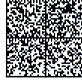

**2D-DOC**

**Vos références**

- **Numéro fiscal (C) :** 01 14 819 263 118
- **Référence de l'avis :** 24 66 A038821 37
- **Adresse d'imposition au 01/01/2024 :** VILLA 32 RESIDENCE DU LAC, 2 AV DU RACOU, 66420 LE BARCARES, 66420 LE BARCARES
- **Numéro FIP :** 660 87 01 4591577789 4 A
- **Numéro de rôle :** 011
- **Date d'établissement :** 08/07/2024
- **Date de mise en recouvrement :** 31/07/2024
- **Identifiant service :** 66038

**Vos contacts**

- **Par messagerie sécurisée**
  - dans votre espace particulier sur Impots.gouv.fr
- **Par téléphone**
  - au 0 809 401 401 *
  - du lundi au vendredi, de 8h30 à 19h
- **Sur place**
  - auprès de votre centre des finances publiques
  - horaires sur Impots.gouv.fr, rubrique Contact et RDV
- **SIP RIVESALTES**
  - SAID 1 MAR I VENTS
  - 9 AVENUE LEDRU ROLLIN
  - CS 80070
  - 66601 RIVESALTES CEDEX

* (service gratuit + coût de l'appel)

**Somme qu'il vous reste à payer**

**0 €**

**Vous n'avez rien à payer au titre des revenus de 2023.**

- **Revenu fiscal de référence :** 13 547
- **Nombre de parts :** 2,00

Plus de détails dans la (les) page (s) suivante (s).

Cet avis fait suite à la déclaration, en 2024, de vos revenus 2023. Le montant porté sur cet avis prend en compte les prélèvements et retenues à la source qui ont pu être réalisés en 2023.

Pour retrouver toutes les informations relatives à votre prélèvement à la source (taux, options ...), rendez-vous sur le service « Gérer mon prélèvement à la source » accessible dans votre espace particulier sur impots.gouv.fr.


## Images de l'OCR

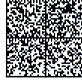

In [65]:
import json
from pathlib import Path
from IPython.display import Markdown, display

def _ensure_data_url(s: str, default_mime="image/png") -> str:
    if not s:
        return ""
    return s if s.startswith("data:") else f"data:{default_mime};base64,{s}"

def render_ocr_result(obj, max_imgs=8):
    """
    obj: dict, chemin d'un fichier .json, ou str(JSON)
    """
    # --- charge en dict ---
    if isinstance(obj, dict):
        data = obj
    else:
        try:
            p = Path(obj)
            if p.is_file():
                data = json.loads(p.read_text(encoding="utf-8"))
            else:
                data = json.loads(obj)
        except Exception as e:
            raise ValueError(f"Impossible de charger l'objet: {e}")

    parts = []

    # 1) EXIF
    exif = data.get("exif") or {}
    if exif:
        parts.append("## EXIF")
        parts += [f"- **{k}** : {v}" for k, v in exif.items()]

    # 2) Markdown OCR (déjà prêt, peut contenir des images inline)
    md = data.get("markdown") or ""
    if md.strip():
        parts.append("\n## OCR")
        parts.append(md.strip())

    # 3) Images renvoyées par l'OCR (si non déjà visibles)
    imgs = data.get("images_from_ocr") or []
    if imgs:
        parts.append("\n## Images de l'OCR")
        for i, durl in enumerate(imgs[:max_imgs], start=1):
            parts.append(f"![ocr {i}]({_ensure_data_url(durl)})")

    # 4) Assets extraits (photos, signatures, tampons, logos)
    assets = data.get("extracted_assets") or {}
    title_map = {
        "face_photos": "Photo d'identité",
        "signatures": "Signatures",
        "stamps": "Tampons / cachets",
        "logos": "Logos",
    }
    for key, title in title_map.items():
        arr = assets.get(key) or []
        if arr:
            parts.append(f"\n## {title} ({len(arr)})")
            for i, durl in enumerate(arr[:max_imgs], start=1):
                parts.append(f"![{key} {i}]({_ensure_data_url(durl)})")

    # 5) Fallback si tout vide
    if not parts:
        parts = ["_Aucun contenu affichable (ni markdown OCR, ni images, ni EXIF)._"]

    # --- Affichage ---
    display(Markdown("\n\n".join(parts)))

# --- Exemple d'appel ---
# Si ton résultat est déjà dans une variable 'result' (dict Python) :
render_ocr_result(result)

# Ou si tu as sauvegardé le JSON sur disque :
# render_ocr_result(r"C:\chemin\vers\result.json")


NB: Using **base64** to encode images converts binary data into a text string. This is useful because:

- **Inline Embedding:** It allows you to embed image data directly within markdown or HTML. This way, you don't need separate image files or additional HTTP requests to load them.
- **Portability:** The image becomes self-contained within the document, making it easier to share and render without relying on external resources.
- **Compatibility:** Some environments or APIs require image data to be in text format, especially when sending data over protocols that only support text.

Overall, base64 encoding simplifies displaying images in environments like Jupyter Notebooks where embedding them directly in the markdown output is convenient.

## Extract structured data from OCR results

**OCR results can be further processed using another model.**

Our goal is to extract structured data from these results. To achieve this, we will utilize the `pixtral-12b-latest` model, supported by our OCR model, to deliver better and higher-quality answers:

In [68]:
# Process OCR results from the receipt image and request a structured JSON conversion using Pixtral 12B
image_ocr_markdown = image_response.pages[0].markdown

# Get structured response from model
chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                ImageURLChunk(image_url=base64_data_url),
                TextChunk(
                    text=(
                        f"This is image's OCR in markdown:\n\n{image_ocr_markdown}\n.\n"
                        "Convert this into a sensible structured json response. "
                        "The output should be strictly be json with no extra commentary"
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# Process OCR results from the receipt image and request a structured JSON conversion using Pixtral 12B
response_dict = json.loads(chat_response.choices[0].message.content)
print(json.dumps(response_dict, indent=4))

{
    "fiscalReference": {
        "fiscalNumber": "01 14 819 263 118",
        "noticeReference": "24 66 A038821 37",
        "address": "VILLA 32 RESIDENCE DU LAC, 2 AV DU RACOU, 66420 LE BARCARES",
        "FIPNumber": "660 87 01 4591577789 4 A",
        "roleNumber": "011",
        "establishmentDate": "08/07/2024",
        "recoveryDate": "31/07/2024",
        "serviceIdentifier": "66038"
    },
    "contacts": {
        "secureMessaging": "dans votre espace particulier sur Impots.gouv.fr",
        "phone": "au 0 809 401 401 * du lundi au vendredi, de 8h30 \u00e0 19h",
        "inPerson": "aupr\u00e8s de votre centre des finances publiques horaires sur Impots.gouv.fr, rubrique Contact et RDV",
        "office": "SIP RIVESALTES SAID 1 MAR I VENTS 9 AVENUE LEDRU ROLLIN CS 80070 66601 RIVESALTES CEDEX"
    },
    "amountDue": "0 \u20ac",
    "message": "Vous n'avez rien \u00e0 payer au titre des revenus de 2023.",
    "fiscalIncome": {
        "referenceIncome": "13 547",
        "nu

**In the example above, we are leveraging a model already capable of vision tasks.**

**However, we could also use text-only models for the structured output. Note in this case, we do not include the image in the user message:**

In [ ]:

# Process OCR results from the receipt image and request a structured JSON conversion using Pixtral 12B
image_ocr_markdown = image_response.pages[0].markdown

# Get structured response from model
chat_response = client.chat.complete(
    model="pixtral-12b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                ImageURLChunk(image_url=base64_data_url),
                TextChunk(
                    text=(
                        f"This is image's OCR in markdown:\n\n{image_ocr_markdown}\n.\n"
                        "Convert this into a sensible structured json response. "
                        "The output should be strictly be json with no extra commentary"
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# Process OCR results from the receipt image and request a structured JSON conversion using Pixtral 12B
response_dict = json.loads(chat_response.choices[0].message.content)
print(json.dumps(response_dict, indent=4))





# Similar to the previous step but using the Ministral 8B model to get a structured JSON response
image_ocr_markdown = image_response.pages[0].markdown

# Get structured response from model using only text no image included
chat_response = client.chat.complete(
    model="ministral-8b-latest",
    messages=[
        {
            "role": "user",
            "content": [
                TextChunk(
                    text=(
                        f"This is image's OCR in markdown:\n\n{image_ocr_markdown}\n.\n"
                        "Convert this into a sensible structured json response. "
                        "The output should be strictly be json with no extra commentary"
                    )
                ),
            ],
        }
    ],
    response_format={"type": "json_object"},
    temperature=0,
)

# Parse and print the JSON response from Ministral 8B
response_dict = json.loads(chat_response.choices[0].message.content)
print(json.dumps(response_dict, indent=4))


{
    "country": "France",
    "department": "Direction G\u00e9n\u00e9rale des Finances Publiques",
    "tax_year": 2023,
    "tax_notice_year": 2024,
    "taxpayer_reference": {
        "fiscal_number": "01 14 819 263 118",
        "notice_reference": "24 66 A038821 37",
        "address": "VILLA 32 RESIDENCE DU LAC, 2 AV DU RACOU, 66420 LE BARCARES"
    },
    "contacts": {
        "email": "impots.gouv.fr",
        "phone": "0 809 401 401",
        "office": "SIP RIVESALTES SAID 1 MAR I VENTS 9 AVENUE LEDRU ROLLIN CS 90070 66601 RIVESALTES CEDEX"
    },
    "amount_due": 0,
    "taxable_income": 13547,
    "number_of_parts": 2,
    "details": "Plus de d\u00e9tails dans la (les) page (s) suivante (s)."
}


## All Together - Mistral OCR + Custom Structured Output

Overall, this integrated approach not only extracts text from visual data but also organizes the extracted information into a machine-readable format, making it more useful for further processing, analysis, or storage.

Let's design a simple function that takes an `image_path` file and returns a JSON structured output in a specific format. In this case, we arbitrarily decided we wanted an output respecting the following:

```python
class StructuredOCR:
    file_name: str  # can be any string
    topics: list[str]  # must be a list of strings
    languages: str  # string
    ocr_contents: dict  # any dictionary, can be freely defined by the model
```

We will make use of [custom structured outputs](https://docs.mistral.ai/capabilities/structured-output/custom_structured_output/).

We can now extract structured output from any image parsed with our OCR model.

In [78]:
# Example usage of the structured_ocr function
image_path = "C:/Users/aliou/OneDrive/Desktop/Mes projets/document_OCR_LLM/ci-anselme-verso.jpg" # Path to sample receipt image
structured_response = structured_ocr(image_path) # Process image and extract data

# # Convert the structured response to a dictionary and print it in JSON format
response_dict = json.loads(structured_response.model_dump_json())
print(json.dumps(response_dict, indent=4))

{
    "file_name": "id_card",
    "topics": [
        "identity card",
        "ocr",
        "document"
    ],
    "languages": "French",
    "ocr_contents": {}
}


The original image for comparison can be found below.

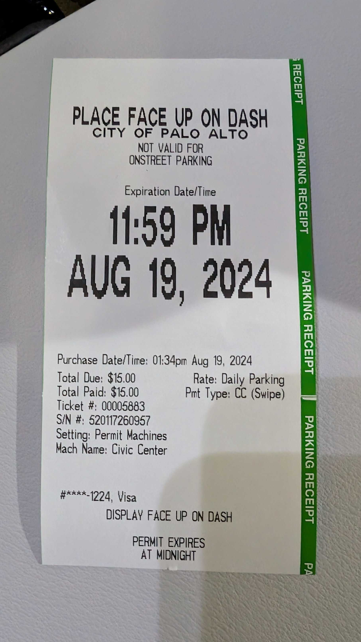

In [37]:
from PIL import Image

# Open and resize the image for visualization purposes
image = Image.open(image_path)
image.resize((image.width // 5, image.height // 5))


# Summary
In summary, this notebook provides a comprehensive demonstration of how to:

Install and set up the necessary Mistral OCR tools.

Download and process both PDF and image files using the OCR service.

Enhance the raw OCR output by embedding images within markdown and converting text into structured JSON data via advanced language models.

Wrap these functionalities into a reusable function to easily process any given image.

This modular and well-documented approach makes it easier to maintain and extend the OCR processing pipeline for various applications, including document analysis and data extraction.